Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


CIFAR-10 Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [28]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))
print (np.shape(train_data))

Train size: 48000
Val size: 1000
Test size: 1000
(48000, 2)


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

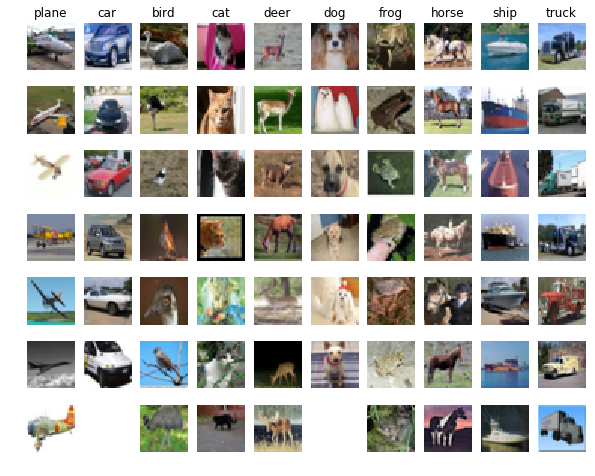

In [29]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

In [30]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN

torch.manual_seed(0)
np.random.seed(0)

X = np.random.randn(2, 3, 5, 5).astype(np.float32)
X_tensor = torch.from_numpy(X.copy())
inputs = Variable(X_tensor)

model = ClassificationCNN(input_dim=(3, 5, 5), num_classes=3)
outputs = model.forward(inputs)
correct_outputs = np.array([[-0.012747,    0.05964366,  0.03898076],
                            [-0.01286934,  0.05963349,  0.03903975]])

# The difference should be very small. We get < 1e-6
print('Difference between the correct and your forward pass:')
print(rel_error(correct_outputs, outputs.data.numpy()))

Difference between the correct and your forward pass:
1.95201428952e-07


## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

In [31]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver import Solver

num_train = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False, num_workers=4,
                                           sampler=OverfitSampler(num_train))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

overfit_model = ClassificationCNN()
overfit_solver = Solver(optim_args={"lr": 1e-2})
overfit_solver.train(overfit_model, train_loader, val_loader, log_nth=1, num_epochs=15)

START AEROPLANE.
[Iteration 0/30] TRAIN loss: 2.310
[Iteration 1/30] TRAIN loss: 4.424
[Epoch 1/15] TRAIN acc/loss: 0.120/4.424
[Epoch 1/15] VAL   acc/loss: 0.111/2.462
[Iteration 2/30] TRAIN loss: 2.569
[Iteration 3/30] TRAIN loss: 2.725
[Epoch 2/15] TRAIN acc/loss: 0.120/2.725


KeyboardInterrupt: 

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(overfit_solver.train_loss_history, 'o')
plt.plot(overfit_solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(overfit_solver.train_acc_history, '-o')
plt.plot(overfit_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [32]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=80, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=80, shuffle=False, num_workers=4)

########################################################################
# TODO: Initialize a model and train it using your Solver class. Start #
# with the previously given set of hyperparameters.                    #
########################################################################

final_model = ClassificationCNN()
final_solver = Solver(optim_args={"lr": 1e-4})
final_solver.train(final_model, train_loader, val_loader, log_nth=1, num_epochs=40)

########################################################################
#                             END OF YOUR CODE                         #
########################################################################

START AEROPLANE.
[Iteration 0/24000] TRAIN loss: 2.305
[Iteration 1/24000] TRAIN loss: 2.300
[Iteration 2/24000] TRAIN loss: 2.317
[Iteration 3/24000] TRAIN loss: 2.305
[Iteration 4/24000] TRAIN loss: 2.303
[Iteration 5/24000] TRAIN loss: 2.294
[Iteration 6/24000] TRAIN loss: 2.306
[Iteration 7/24000] TRAIN loss: 2.297
[Iteration 8/24000] TRAIN loss: 2.298
[Iteration 9/24000] TRAIN loss: 2.308
[Iteration 10/24000] TRAIN loss: 2.301
[Iteration 11/24000] TRAIN loss: 2.298
[Iteration 12/24000] TRAIN loss: 2.310
[Iteration 13/24000] TRAIN loss: 2.301
[Iteration 14/24000] TRAIN loss: 2.303
[Iteration 15/24000] TRAIN loss: 2.309
[Iteration 16/24000] TRAIN loss: 2.305
[Iteration 17/24000] TRAIN loss: 2.300
[Iteration 18/24000] TRAIN loss: 2.300
[Iteration 19/24000] TRAIN loss: 2.283
[Iteration 20/24000] TRAIN loss: 2.301
[Iteration 21/24000] TRAIN loss: 2.304
[Iteration 22/24000] TRAIN loss: 2.292
[Iteration 23/24000] TRAIN loss: 2.297
[Iteration 24/24000] TRAIN loss: 2.295
[Iteration 25/2400

[Iteration 215/24000] TRAIN loss: 1.953
[Iteration 216/24000] TRAIN loss: 1.924
[Iteration 217/24000] TRAIN loss: 1.899
[Iteration 218/24000] TRAIN loss: 1.985
[Iteration 219/24000] TRAIN loss: 1.968
[Iteration 220/24000] TRAIN loss: 1.932
[Iteration 221/24000] TRAIN loss: 1.923
[Iteration 222/24000] TRAIN loss: 1.938
[Iteration 223/24000] TRAIN loss: 1.991
[Iteration 224/24000] TRAIN loss: 1.898
[Iteration 225/24000] TRAIN loss: 1.972
[Iteration 226/24000] TRAIN loss: 1.932
[Iteration 227/24000] TRAIN loss: 1.983
[Iteration 228/24000] TRAIN loss: 1.909
[Iteration 229/24000] TRAIN loss: 2.066
[Iteration 230/24000] TRAIN loss: 1.980
[Iteration 231/24000] TRAIN loss: 2.020
[Iteration 232/24000] TRAIN loss: 2.036
[Iteration 233/24000] TRAIN loss: 1.963
[Iteration 234/24000] TRAIN loss: 1.853
[Iteration 235/24000] TRAIN loss: 1.944
[Iteration 236/24000] TRAIN loss: 1.900
[Iteration 237/24000] TRAIN loss: 1.901
[Iteration 238/24000] TRAIN loss: 1.898
[Iteration 239/24000] TRAIN loss: 1.981


[Iteration 419/24000] TRAIN loss: 1.599
[Iteration 420/24000] TRAIN loss: 1.907
[Iteration 421/24000] TRAIN loss: 1.683
[Iteration 422/24000] TRAIN loss: 1.767
[Iteration 423/24000] TRAIN loss: 1.789
[Iteration 424/24000] TRAIN loss: 1.714
[Iteration 425/24000] TRAIN loss: 1.921
[Iteration 426/24000] TRAIN loss: 1.696
[Iteration 427/24000] TRAIN loss: 1.756
[Iteration 428/24000] TRAIN loss: 1.992
[Iteration 429/24000] TRAIN loss: 1.852
[Iteration 430/24000] TRAIN loss: 1.815
[Iteration 431/24000] TRAIN loss: 1.894
[Iteration 432/24000] TRAIN loss: 1.763
[Iteration 433/24000] TRAIN loss: 1.863
[Iteration 434/24000] TRAIN loss: 1.825
[Iteration 435/24000] TRAIN loss: 1.881
[Iteration 436/24000] TRAIN loss: 1.742
[Iteration 437/24000] TRAIN loss: 1.782
[Iteration 438/24000] TRAIN loss: 1.733
[Iteration 439/24000] TRAIN loss: 1.798
[Iteration 440/24000] TRAIN loss: 1.816
[Iteration 441/24000] TRAIN loss: 1.785
[Iteration 442/24000] TRAIN loss: 1.867
[Iteration 443/24000] TRAIN loss: 1.823


[Iteration 641/24000] TRAIN loss: 1.618
[Iteration 642/24000] TRAIN loss: 1.640
[Iteration 643/24000] TRAIN loss: 1.708
[Iteration 644/24000] TRAIN loss: 1.826
[Iteration 645/24000] TRAIN loss: 1.740
[Iteration 646/24000] TRAIN loss: 1.801
[Iteration 647/24000] TRAIN loss: 1.659
[Iteration 648/24000] TRAIN loss: 1.688
[Iteration 649/24000] TRAIN loss: 1.681
[Iteration 650/24000] TRAIN loss: 1.598
[Iteration 651/24000] TRAIN loss: 1.720
[Iteration 652/24000] TRAIN loss: 1.643
[Iteration 653/24000] TRAIN loss: 1.761
[Iteration 654/24000] TRAIN loss: 1.715
[Iteration 655/24000] TRAIN loss: 1.664
[Iteration 656/24000] TRAIN loss: 1.636
[Iteration 657/24000] TRAIN loss: 1.642
[Iteration 658/24000] TRAIN loss: 1.617
[Iteration 659/24000] TRAIN loss: 1.706
[Iteration 660/24000] TRAIN loss: 1.731
[Iteration 661/24000] TRAIN loss: 1.650
[Iteration 662/24000] TRAIN loss: 1.700
[Iteration 663/24000] TRAIN loss: 1.737
[Iteration 664/24000] TRAIN loss: 1.767
[Iteration 665/24000] TRAIN loss: 1.603


[Iteration 852/24000] TRAIN loss: 1.656
[Iteration 853/24000] TRAIN loss: 1.673
[Iteration 854/24000] TRAIN loss: 1.615
[Iteration 855/24000] TRAIN loss: 1.537
[Iteration 856/24000] TRAIN loss: 1.568
[Iteration 857/24000] TRAIN loss: 1.512
[Iteration 858/24000] TRAIN loss: 1.827
[Iteration 859/24000] TRAIN loss: 1.482
[Iteration 860/24000] TRAIN loss: 1.616
[Iteration 861/24000] TRAIN loss: 1.621
[Iteration 862/24000] TRAIN loss: 1.777
[Iteration 863/24000] TRAIN loss: 1.639
[Iteration 864/24000] TRAIN loss: 1.598
[Iteration 865/24000] TRAIN loss: 1.567
[Iteration 866/24000] TRAIN loss: 1.467
[Iteration 867/24000] TRAIN loss: 1.639
[Iteration 868/24000] TRAIN loss: 1.743
[Iteration 869/24000] TRAIN loss: 1.578
[Iteration 870/24000] TRAIN loss: 1.581
[Iteration 871/24000] TRAIN loss: 1.707
[Iteration 872/24000] TRAIN loss: 1.738
[Iteration 873/24000] TRAIN loss: 1.522
[Iteration 874/24000] TRAIN loss: 1.736
[Iteration 875/24000] TRAIN loss: 1.483
[Iteration 876/24000] TRAIN loss: 1.780


[Iteration 1063/24000] TRAIN loss: 1.462
[Iteration 1064/24000] TRAIN loss: 1.691
[Iteration 1065/24000] TRAIN loss: 1.424
[Iteration 1066/24000] TRAIN loss: 1.567
[Iteration 1067/24000] TRAIN loss: 1.621
[Iteration 1068/24000] TRAIN loss: 1.815
[Iteration 1069/24000] TRAIN loss: 1.474
[Iteration 1070/24000] TRAIN loss: 1.642
[Iteration 1071/24000] TRAIN loss: 1.378
[Iteration 1072/24000] TRAIN loss: 1.510
[Iteration 1073/24000] TRAIN loss: 1.470
[Iteration 1074/24000] TRAIN loss: 1.700
[Iteration 1075/24000] TRAIN loss: 1.554
[Iteration 1076/24000] TRAIN loss: 1.777
[Iteration 1077/24000] TRAIN loss: 1.458
[Iteration 1078/24000] TRAIN loss: 1.757
[Iteration 1079/24000] TRAIN loss: 1.795
[Iteration 1080/24000] TRAIN loss: 1.739
[Iteration 1081/24000] TRAIN loss: 1.395
[Iteration 1082/24000] TRAIN loss: 1.669
[Iteration 1083/24000] TRAIN loss: 1.693
[Iteration 1084/24000] TRAIN loss: 1.817
[Iteration 1085/24000] TRAIN loss: 1.561
[Iteration 1086/24000] TRAIN loss: 1.556
[Iteration 1087/

[Iteration 1273/24000] TRAIN loss: 1.598
[Iteration 1274/24000] TRAIN loss: 1.726
[Iteration 1275/24000] TRAIN loss: 1.671
[Iteration 1276/24000] TRAIN loss: 1.424
[Iteration 1277/24000] TRAIN loss: 1.928
[Iteration 1278/24000] TRAIN loss: 1.588
[Iteration 1279/24000] TRAIN loss: 1.764
[Iteration 1280/24000] TRAIN loss: 1.544
[Iteration 1281/24000] TRAIN loss: 1.523
[Iteration 1282/24000] TRAIN loss: 1.572
[Iteration 1283/24000] TRAIN loss: 1.644
[Iteration 1284/24000] TRAIN loss: 1.346
[Iteration 1285/24000] TRAIN loss: 1.635
[Iteration 1286/24000] TRAIN loss: 1.562
[Iteration 1287/24000] TRAIN loss: 1.462
[Iteration 1288/24000] TRAIN loss: 1.783
[Iteration 1289/24000] TRAIN loss: 1.466
[Iteration 1290/24000] TRAIN loss: 1.475
[Iteration 1291/24000] TRAIN loss: 1.611
[Iteration 1292/24000] TRAIN loss: 1.652
[Iteration 1293/24000] TRAIN loss: 1.554
[Iteration 1294/24000] TRAIN loss: 1.750
[Iteration 1295/24000] TRAIN loss: 1.525
[Iteration 1296/24000] TRAIN loss: 1.596
[Iteration 1297/

[Iteration 1476/24000] TRAIN loss: 1.637
[Iteration 1477/24000] TRAIN loss: 1.602
[Iteration 1478/24000] TRAIN loss: 1.654
[Iteration 1479/24000] TRAIN loss: 1.534
[Iteration 1480/24000] TRAIN loss: 1.708
[Iteration 1481/24000] TRAIN loss: 1.528
[Iteration 1482/24000] TRAIN loss: 1.490
[Iteration 1483/24000] TRAIN loss: 1.740
[Iteration 1484/24000] TRAIN loss: 1.562
[Iteration 1485/24000] TRAIN loss: 1.471
[Iteration 1486/24000] TRAIN loss: 1.497
[Iteration 1487/24000] TRAIN loss: 1.591
[Iteration 1488/24000] TRAIN loss: 1.696
[Iteration 1489/24000] TRAIN loss: 1.594
[Iteration 1490/24000] TRAIN loss: 1.714
[Iteration 1491/24000] TRAIN loss: 1.557
[Iteration 1492/24000] TRAIN loss: 1.622
[Iteration 1493/24000] TRAIN loss: 1.554
[Iteration 1494/24000] TRAIN loss: 1.509
[Iteration 1495/24000] TRAIN loss: 1.647
[Iteration 1496/24000] TRAIN loss: 1.507
[Iteration 1497/24000] TRAIN loss: 1.751
[Iteration 1498/24000] TRAIN loss: 1.574
[Iteration 1499/24000] TRAIN loss: 1.627
[Iteration 1500/

[Iteration 1678/24000] TRAIN loss: 1.732
[Iteration 1679/24000] TRAIN loss: 1.424
[Iteration 1680/24000] TRAIN loss: 1.539
[Iteration 1681/24000] TRAIN loss: 1.457
[Iteration 1682/24000] TRAIN loss: 1.745
[Iteration 1683/24000] TRAIN loss: 1.556
[Iteration 1684/24000] TRAIN loss: 1.292
[Iteration 1685/24000] TRAIN loss: 1.638
[Iteration 1686/24000] TRAIN loss: 1.593
[Iteration 1687/24000] TRAIN loss: 1.609
[Iteration 1688/24000] TRAIN loss: 1.498
[Iteration 1689/24000] TRAIN loss: 1.748
[Iteration 1690/24000] TRAIN loss: 1.546
[Iteration 1691/24000] TRAIN loss: 1.451
[Iteration 1692/24000] TRAIN loss: 1.521
[Iteration 1693/24000] TRAIN loss: 1.622
[Iteration 1694/24000] TRAIN loss: 1.492
[Iteration 1695/24000] TRAIN loss: 1.584
[Iteration 1696/24000] TRAIN loss: 1.394
[Iteration 1697/24000] TRAIN loss: 1.718
[Iteration 1698/24000] TRAIN loss: 1.481
[Iteration 1699/24000] TRAIN loss: 1.649
[Iteration 1700/24000] TRAIN loss: 1.600
[Iteration 1701/24000] TRAIN loss: 1.554
[Iteration 1702/

[Iteration 1880/24000] TRAIN loss: 1.602
[Iteration 1881/24000] TRAIN loss: 1.524
[Iteration 1882/24000] TRAIN loss: 1.480
[Iteration 1883/24000] TRAIN loss: 1.691
[Iteration 1884/24000] TRAIN loss: 1.629
[Iteration 1885/24000] TRAIN loss: 1.770
[Iteration 1886/24000] TRAIN loss: 1.579
[Iteration 1887/24000] TRAIN loss: 1.606
[Iteration 1888/24000] TRAIN loss: 1.435
[Iteration 1889/24000] TRAIN loss: 1.897
[Iteration 1890/24000] TRAIN loss: 1.536
[Iteration 1891/24000] TRAIN loss: 1.393
[Iteration 1892/24000] TRAIN loss: 1.372
[Iteration 1893/24000] TRAIN loss: 1.335
[Iteration 1894/24000] TRAIN loss: 1.563
[Iteration 1895/24000] TRAIN loss: 1.404
[Iteration 1896/24000] TRAIN loss: 1.338
[Iteration 1897/24000] TRAIN loss: 1.453
[Iteration 1898/24000] TRAIN loss: 1.594
[Iteration 1899/24000] TRAIN loss: 1.397
[Iteration 1900/24000] TRAIN loss: 1.490
[Iteration 1901/24000] TRAIN loss: 1.542
[Iteration 1902/24000] TRAIN loss: 1.523
[Iteration 1903/24000] TRAIN loss: 1.478
[Iteration 1904/

[Iteration 2083/24000] TRAIN loss: 1.510
[Iteration 2084/24000] TRAIN loss: 1.411
[Iteration 2085/24000] TRAIN loss: 1.418
[Iteration 2086/24000] TRAIN loss: 1.453
[Iteration 2087/24000] TRAIN loss: 1.280
[Iteration 2088/24000] TRAIN loss: 1.662
[Iteration 2089/24000] TRAIN loss: 1.443
[Iteration 2090/24000] TRAIN loss: 1.500
[Iteration 2091/24000] TRAIN loss: 1.388
[Iteration 2092/24000] TRAIN loss: 1.568
[Iteration 2093/24000] TRAIN loss: 1.595
[Iteration 2094/24000] TRAIN loss: 1.426
[Iteration 2095/24000] TRAIN loss: 1.526
[Iteration 2096/24000] TRAIN loss: 1.670
[Iteration 2097/24000] TRAIN loss: 1.471
[Iteration 2098/24000] TRAIN loss: 1.493
[Iteration 2099/24000] TRAIN loss: 1.800
[Iteration 2100/24000] TRAIN loss: 1.557
[Iteration 2101/24000] TRAIN loss: 1.484
[Iteration 2102/24000] TRAIN loss: 1.653
[Iteration 2103/24000] TRAIN loss: 1.730
[Iteration 2104/24000] TRAIN loss: 1.567
[Iteration 2105/24000] TRAIN loss: 1.637
[Iteration 2106/24000] TRAIN loss: 1.517
[Iteration 2107/

[Iteration 2295/24000] TRAIN loss: 1.607
[Iteration 2296/24000] TRAIN loss: 1.595
[Iteration 2297/24000] TRAIN loss: 1.407
[Iteration 2298/24000] TRAIN loss: 1.648
[Iteration 2299/24000] TRAIN loss: 1.411
[Iteration 2300/24000] TRAIN loss: 1.643
[Iteration 2301/24000] TRAIN loss: 1.657
[Iteration 2302/24000] TRAIN loss: 1.381
[Iteration 2303/24000] TRAIN loss: 1.366
[Iteration 2304/24000] TRAIN loss: 1.349
[Iteration 2305/24000] TRAIN loss: 1.629
[Iteration 2306/24000] TRAIN loss: 1.665
[Iteration 2307/24000] TRAIN loss: 1.624
[Iteration 2308/24000] TRAIN loss: 1.466
[Iteration 2309/24000] TRAIN loss: 1.495
[Iteration 2310/24000] TRAIN loss: 1.550
[Iteration 2311/24000] TRAIN loss: 1.249
[Iteration 2312/24000] TRAIN loss: 1.480
[Iteration 2313/24000] TRAIN loss: 1.309
[Iteration 2314/24000] TRAIN loss: 1.524
[Iteration 2315/24000] TRAIN loss: 1.499
[Iteration 2316/24000] TRAIN loss: 1.492
[Iteration 2317/24000] TRAIN loss: 1.501
[Iteration 2318/24000] TRAIN loss: 1.398
[Iteration 2319/

[Iteration 2493/24000] TRAIN loss: 1.548
[Iteration 2494/24000] TRAIN loss: 1.369
[Iteration 2495/24000] TRAIN loss: 1.595
[Iteration 2496/24000] TRAIN loss: 1.426
[Iteration 2497/24000] TRAIN loss: 1.511
[Iteration 2498/24000] TRAIN loss: 1.515
[Iteration 2499/24000] TRAIN loss: 1.387
[Iteration 2500/24000] TRAIN loss: 1.524
[Iteration 2501/24000] TRAIN loss: 1.481
[Iteration 2502/24000] TRAIN loss: 1.369
[Iteration 2503/24000] TRAIN loss: 1.641
[Iteration 2504/24000] TRAIN loss: 1.556
[Iteration 2505/24000] TRAIN loss: 1.265
[Iteration 2506/24000] TRAIN loss: 1.295
[Iteration 2507/24000] TRAIN loss: 1.474
[Iteration 2508/24000] TRAIN loss: 1.526
[Iteration 2509/24000] TRAIN loss: 1.589
[Iteration 2510/24000] TRAIN loss: 1.420
[Iteration 2511/24000] TRAIN loss: 1.553
[Iteration 2512/24000] TRAIN loss: 1.461
[Iteration 2513/24000] TRAIN loss: 1.410
[Iteration 2514/24000] TRAIN loss: 1.411
[Iteration 2515/24000] TRAIN loss: 1.535
[Iteration 2516/24000] TRAIN loss: 1.515
[Iteration 2517/

[Iteration 2694/24000] TRAIN loss: 1.378
[Iteration 2695/24000] TRAIN loss: 1.495
[Iteration 2696/24000] TRAIN loss: 1.553
[Iteration 2697/24000] TRAIN loss: 1.458
[Iteration 2698/24000] TRAIN loss: 1.390
[Iteration 2699/24000] TRAIN loss: 1.373
[Iteration 2700/24000] TRAIN loss: 1.389
[Iteration 2701/24000] TRAIN loss: 1.486
[Iteration 2702/24000] TRAIN loss: 1.580
[Iteration 2703/24000] TRAIN loss: 1.259
[Iteration 2704/24000] TRAIN loss: 1.487
[Iteration 2705/24000] TRAIN loss: 1.630
[Iteration 2706/24000] TRAIN loss: 1.456
[Iteration 2707/24000] TRAIN loss: 1.560
[Iteration 2708/24000] TRAIN loss: 1.561
[Iteration 2709/24000] TRAIN loss: 1.563
[Iteration 2710/24000] TRAIN loss: 1.490
[Iteration 2711/24000] TRAIN loss: 1.311
[Iteration 2712/24000] TRAIN loss: 1.505
[Iteration 2713/24000] TRAIN loss: 1.454
[Iteration 2714/24000] TRAIN loss: 1.482
[Iteration 2715/24000] TRAIN loss: 1.442
[Iteration 2716/24000] TRAIN loss: 1.441
[Iteration 2717/24000] TRAIN loss: 1.395
[Iteration 2718/

[Iteration 2896/24000] TRAIN loss: 1.453
[Iteration 2897/24000] TRAIN loss: 1.504
[Iteration 2898/24000] TRAIN loss: 1.487
[Iteration 2899/24000] TRAIN loss: 1.447
[Iteration 2900/24000] TRAIN loss: 1.286
[Iteration 2901/24000] TRAIN loss: 1.554
[Iteration 2902/24000] TRAIN loss: 1.485
[Iteration 2903/24000] TRAIN loss: 1.444
[Iteration 2904/24000] TRAIN loss: 1.489
[Iteration 2905/24000] TRAIN loss: 1.330
[Iteration 2906/24000] TRAIN loss: 1.257
[Iteration 2907/24000] TRAIN loss: 1.522
[Iteration 2908/24000] TRAIN loss: 1.407
[Iteration 2909/24000] TRAIN loss: 1.490
[Iteration 2910/24000] TRAIN loss: 1.460
[Iteration 2911/24000] TRAIN loss: 1.461
[Iteration 2912/24000] TRAIN loss: 1.610
[Iteration 2913/24000] TRAIN loss: 1.390
[Iteration 2914/24000] TRAIN loss: 1.434
[Iteration 2915/24000] TRAIN loss: 1.407
[Iteration 2916/24000] TRAIN loss: 1.388
[Iteration 2917/24000] TRAIN loss: 1.247
[Iteration 2918/24000] TRAIN loss: 1.549
[Iteration 2919/24000] TRAIN loss: 1.307
[Iteration 2920/

[Iteration 3110/24000] TRAIN loss: 1.262
[Iteration 3111/24000] TRAIN loss: 1.351
[Iteration 3112/24000] TRAIN loss: 1.295
[Iteration 3113/24000] TRAIN loss: 1.386
[Iteration 3114/24000] TRAIN loss: 1.384
[Iteration 3115/24000] TRAIN loss: 1.505
[Iteration 3116/24000] TRAIN loss: 1.388
[Iteration 3117/24000] TRAIN loss: 1.496
[Iteration 3118/24000] TRAIN loss: 1.413
[Iteration 3119/24000] TRAIN loss: 1.490
[Iteration 3120/24000] TRAIN loss: 1.889
[Iteration 3121/24000] TRAIN loss: 1.481
[Iteration 3122/24000] TRAIN loss: 1.432
[Iteration 3123/24000] TRAIN loss: 1.403
[Iteration 3124/24000] TRAIN loss: 1.531
[Iteration 3125/24000] TRAIN loss: 1.506
[Iteration 3126/24000] TRAIN loss: 1.326
[Iteration 3127/24000] TRAIN loss: 1.493
[Iteration 3128/24000] TRAIN loss: 1.310
[Iteration 3129/24000] TRAIN loss: 1.268
[Iteration 3130/24000] TRAIN loss: 1.494
[Iteration 3131/24000] TRAIN loss: 1.563
[Iteration 3132/24000] TRAIN loss: 1.436
[Iteration 3133/24000] TRAIN loss: 1.674
[Iteration 3134/

[Iteration 3318/24000] TRAIN loss: 1.281
[Iteration 3319/24000] TRAIN loss: 1.317
[Iteration 3320/24000] TRAIN loss: 1.385
[Iteration 3321/24000] TRAIN loss: 1.270
[Iteration 3322/24000] TRAIN loss: 1.457
[Iteration 3323/24000] TRAIN loss: 1.506
[Iteration 3324/24000] TRAIN loss: 1.394
[Iteration 3325/24000] TRAIN loss: 1.407
[Iteration 3326/24000] TRAIN loss: 1.409
[Iteration 3327/24000] TRAIN loss: 1.380
[Iteration 3328/24000] TRAIN loss: 1.420
[Iteration 3329/24000] TRAIN loss: 1.342
[Iteration 3330/24000] TRAIN loss: 1.141
[Iteration 3331/24000] TRAIN loss: 1.411
[Iteration 3332/24000] TRAIN loss: 1.368
[Iteration 3333/24000] TRAIN loss: 1.537
[Iteration 3334/24000] TRAIN loss: 1.504
[Iteration 3335/24000] TRAIN loss: 1.322
[Iteration 3336/24000] TRAIN loss: 1.618
[Iteration 3337/24000] TRAIN loss: 1.605
[Iteration 3338/24000] TRAIN loss: 1.381
[Iteration 3339/24000] TRAIN loss: 1.403
[Iteration 3340/24000] TRAIN loss: 1.224
[Iteration 3341/24000] TRAIN loss: 1.521
[Iteration 3342/

[Iteration 3521/24000] TRAIN loss: 1.422
[Iteration 3522/24000] TRAIN loss: 1.463
[Iteration 3523/24000] TRAIN loss: 1.169
[Iteration 3524/24000] TRAIN loss: 1.365
[Iteration 3525/24000] TRAIN loss: 1.399
[Iteration 3526/24000] TRAIN loss: 1.318
[Iteration 3527/24000] TRAIN loss: 1.270
[Iteration 3528/24000] TRAIN loss: 1.441
[Iteration 3529/24000] TRAIN loss: 1.386
[Iteration 3530/24000] TRAIN loss: 1.311
[Iteration 3531/24000] TRAIN loss: 1.405
[Iteration 3532/24000] TRAIN loss: 1.393
[Iteration 3533/24000] TRAIN loss: 1.298
[Iteration 3534/24000] TRAIN loss: 1.287
[Iteration 3535/24000] TRAIN loss: 1.319
[Iteration 3536/24000] TRAIN loss: 1.340
[Iteration 3537/24000] TRAIN loss: 1.454
[Iteration 3538/24000] TRAIN loss: 1.448
[Iteration 3539/24000] TRAIN loss: 1.352
[Iteration 3540/24000] TRAIN loss: 1.368
[Iteration 3541/24000] TRAIN loss: 1.402
[Iteration 3542/24000] TRAIN loss: 1.450
[Iteration 3543/24000] TRAIN loss: 1.494
[Iteration 3544/24000] TRAIN loss: 1.313
[Iteration 3545/

[Iteration 3720/24000] TRAIN loss: 1.362
[Iteration 3721/24000] TRAIN loss: 1.406
[Iteration 3722/24000] TRAIN loss: 1.409
[Iteration 3723/24000] TRAIN loss: 1.167
[Iteration 3724/24000] TRAIN loss: 1.340
[Iteration 3725/24000] TRAIN loss: 1.315
[Iteration 3726/24000] TRAIN loss: 1.470
[Iteration 3727/24000] TRAIN loss: 1.398
[Iteration 3728/24000] TRAIN loss: 1.401
[Iteration 3729/24000] TRAIN loss: 1.507
[Iteration 3730/24000] TRAIN loss: 1.500
[Iteration 3731/24000] TRAIN loss: 1.346
[Iteration 3732/24000] TRAIN loss: 1.311
[Iteration 3733/24000] TRAIN loss: 1.360
[Iteration 3734/24000] TRAIN loss: 1.437
[Iteration 3735/24000] TRAIN loss: 1.208
[Iteration 3736/24000] TRAIN loss: 1.325
[Iteration 3737/24000] TRAIN loss: 1.355
[Iteration 3738/24000] TRAIN loss: 1.384
[Iteration 3739/24000] TRAIN loss: 1.244
[Iteration 3740/24000] TRAIN loss: 1.249
[Iteration 3741/24000] TRAIN loss: 1.411
[Iteration 3742/24000] TRAIN loss: 1.421
[Iteration 3743/24000] TRAIN loss: 1.295
[Iteration 3744/

[Iteration 3926/24000] TRAIN loss: 1.429
[Iteration 3927/24000] TRAIN loss: 1.298
[Iteration 3928/24000] TRAIN loss: 1.231
[Iteration 3929/24000] TRAIN loss: 1.571
[Iteration 3930/24000] TRAIN loss: 1.399
[Iteration 3931/24000] TRAIN loss: 1.470
[Iteration 3932/24000] TRAIN loss: 1.293
[Iteration 3933/24000] TRAIN loss: 1.143
[Iteration 3934/24000] TRAIN loss: 1.282
[Iteration 3935/24000] TRAIN loss: 1.354
[Iteration 3936/24000] TRAIN loss: 1.330
[Iteration 3937/24000] TRAIN loss: 1.137
[Iteration 3938/24000] TRAIN loss: 1.700
[Iteration 3939/24000] TRAIN loss: 1.365
[Iteration 3940/24000] TRAIN loss: 1.294
[Iteration 3941/24000] TRAIN loss: 1.279
[Iteration 3942/24000] TRAIN loss: 1.346
[Iteration 3943/24000] TRAIN loss: 1.221
[Iteration 3944/24000] TRAIN loss: 1.359
[Iteration 3945/24000] TRAIN loss: 1.534
[Iteration 3946/24000] TRAIN loss: 1.345
[Iteration 3947/24000] TRAIN loss: 1.357
[Iteration 3948/24000] TRAIN loss: 1.308
[Iteration 3949/24000] TRAIN loss: 1.167
[Iteration 3950/

[Iteration 4137/24000] TRAIN loss: 1.290
[Iteration 4138/24000] TRAIN loss: 1.375
[Iteration 4139/24000] TRAIN loss: 1.326
[Iteration 4140/24000] TRAIN loss: 1.173
[Iteration 4141/24000] TRAIN loss: 1.312
[Iteration 4142/24000] TRAIN loss: 1.268
[Iteration 4143/24000] TRAIN loss: 1.165
[Iteration 4144/24000] TRAIN loss: 1.310
[Iteration 4145/24000] TRAIN loss: 1.368
[Iteration 4146/24000] TRAIN loss: 1.421
[Iteration 4147/24000] TRAIN loss: 1.492
[Iteration 4148/24000] TRAIN loss: 1.353
[Iteration 4149/24000] TRAIN loss: 1.226
[Iteration 4150/24000] TRAIN loss: 1.494
[Iteration 4151/24000] TRAIN loss: 1.335
[Iteration 4152/24000] TRAIN loss: 1.226
[Iteration 4153/24000] TRAIN loss: 1.267
[Iteration 4154/24000] TRAIN loss: 1.206
[Iteration 4155/24000] TRAIN loss: 1.262
[Iteration 4156/24000] TRAIN loss: 1.287
[Iteration 4157/24000] TRAIN loss: 1.431
[Iteration 4158/24000] TRAIN loss: 1.363
[Iteration 4159/24000] TRAIN loss: 1.289
[Iteration 4160/24000] TRAIN loss: 1.102
[Iteration 4161/

[Iteration 4338/24000] TRAIN loss: 1.534
[Iteration 4339/24000] TRAIN loss: 1.438
[Iteration 4340/24000] TRAIN loss: 1.341
[Iteration 4341/24000] TRAIN loss: 1.400
[Iteration 4342/24000] TRAIN loss: 1.188
[Iteration 4343/24000] TRAIN loss: 1.304
[Iteration 4344/24000] TRAIN loss: 1.394
[Iteration 4345/24000] TRAIN loss: 1.285
[Iteration 4346/24000] TRAIN loss: 1.376
[Iteration 4347/24000] TRAIN loss: 1.330
[Iteration 4348/24000] TRAIN loss: 1.354
[Iteration 4349/24000] TRAIN loss: 1.229
[Iteration 4350/24000] TRAIN loss: 1.329
[Iteration 4351/24000] TRAIN loss: 1.576
[Iteration 4352/24000] TRAIN loss: 1.440
[Iteration 4353/24000] TRAIN loss: 1.283
[Iteration 4354/24000] TRAIN loss: 1.274
[Iteration 4355/24000] TRAIN loss: 1.223
[Iteration 4356/24000] TRAIN loss: 1.506
[Iteration 4357/24000] TRAIN loss: 1.575
[Iteration 4358/24000] TRAIN loss: 1.284
[Iteration 4359/24000] TRAIN loss: 1.389
[Iteration 4360/24000] TRAIN loss: 1.401
[Iteration 4361/24000] TRAIN loss: 1.209
[Iteration 4362/

[Iteration 4540/24000] TRAIN loss: 1.249
[Iteration 4541/24000] TRAIN loss: 1.237
[Iteration 4542/24000] TRAIN loss: 1.386
[Iteration 4543/24000] TRAIN loss: 1.087
[Iteration 4544/24000] TRAIN loss: 1.360
[Iteration 4545/24000] TRAIN loss: 1.207
[Iteration 4546/24000] TRAIN loss: 1.381
[Iteration 4547/24000] TRAIN loss: 1.252
[Iteration 4548/24000] TRAIN loss: 1.237
[Iteration 4549/24000] TRAIN loss: 1.327
[Iteration 4550/24000] TRAIN loss: 1.297
[Iteration 4551/24000] TRAIN loss: 1.213
[Iteration 4552/24000] TRAIN loss: 1.292
[Iteration 4553/24000] TRAIN loss: 1.302
[Iteration 4554/24000] TRAIN loss: 1.355
[Iteration 4555/24000] TRAIN loss: 1.136
[Iteration 4556/24000] TRAIN loss: 1.150
[Iteration 4557/24000] TRAIN loss: 1.130
[Iteration 4558/24000] TRAIN loss: 1.528
[Iteration 4559/24000] TRAIN loss: 1.298
[Iteration 4560/24000] TRAIN loss: 1.457
[Iteration 4561/24000] TRAIN loss: 1.363
[Iteration 4562/24000] TRAIN loss: 1.074
[Iteration 4563/24000] TRAIN loss: 1.339
[Iteration 4564/

[Iteration 4745/24000] TRAIN loss: 1.135
[Iteration 4746/24000] TRAIN loss: 1.374
[Iteration 4747/24000] TRAIN loss: 1.336
[Iteration 4748/24000] TRAIN loss: 1.290
[Iteration 4749/24000] TRAIN loss: 1.455
[Iteration 4750/24000] TRAIN loss: 1.177
[Iteration 4751/24000] TRAIN loss: 1.377
[Iteration 4752/24000] TRAIN loss: 1.511
[Iteration 4753/24000] TRAIN loss: 1.352
[Iteration 4754/24000] TRAIN loss: 1.445
[Iteration 4755/24000] TRAIN loss: 1.162
[Iteration 4756/24000] TRAIN loss: 1.307
[Iteration 4757/24000] TRAIN loss: 1.434
[Iteration 4758/24000] TRAIN loss: 1.387
[Iteration 4759/24000] TRAIN loss: 1.337
[Iteration 4760/24000] TRAIN loss: 1.414
[Iteration 4761/24000] TRAIN loss: 1.351
[Iteration 4762/24000] TRAIN loss: 1.208
[Iteration 4763/24000] TRAIN loss: 1.290
[Iteration 4764/24000] TRAIN loss: 1.390
[Iteration 4765/24000] TRAIN loss: 1.188
[Iteration 4766/24000] TRAIN loss: 1.518
[Iteration 4767/24000] TRAIN loss: 1.349
[Iteration 4768/24000] TRAIN loss: 1.462
[Iteration 4769/

[Iteration 4947/24000] TRAIN loss: 1.178
[Iteration 4948/24000] TRAIN loss: 1.304
[Iteration 4949/24000] TRAIN loss: 1.190
[Iteration 4950/24000] TRAIN loss: 1.237
[Iteration 4951/24000] TRAIN loss: 1.395
[Iteration 4952/24000] TRAIN loss: 1.323
[Iteration 4953/24000] TRAIN loss: 1.249
[Iteration 4954/24000] TRAIN loss: 1.240
[Iteration 4955/24000] TRAIN loss: 1.275
[Iteration 4956/24000] TRAIN loss: 1.197
[Iteration 4957/24000] TRAIN loss: 1.243
[Iteration 4958/24000] TRAIN loss: 1.243
[Iteration 4959/24000] TRAIN loss: 1.321
[Iteration 4960/24000] TRAIN loss: 1.220
[Iteration 4961/24000] TRAIN loss: 1.336
[Iteration 4962/24000] TRAIN loss: 1.266
[Iteration 4963/24000] TRAIN loss: 1.425
[Iteration 4964/24000] TRAIN loss: 1.232
[Iteration 4965/24000] TRAIN loss: 1.215
[Iteration 4966/24000] TRAIN loss: 1.590
[Iteration 4967/24000] TRAIN loss: 1.474
[Iteration 4968/24000] TRAIN loss: 1.367
[Iteration 4969/24000] TRAIN loss: 1.268
[Iteration 4970/24000] TRAIN loss: 1.244
[Iteration 4971/

[Iteration 5158/24000] TRAIN loss: 1.205
[Iteration 5159/24000] TRAIN loss: 1.385
[Iteration 5160/24000] TRAIN loss: 1.589
[Iteration 5161/24000] TRAIN loss: 1.465
[Iteration 5162/24000] TRAIN loss: 1.498
[Iteration 5163/24000] TRAIN loss: 1.403
[Iteration 5164/24000] TRAIN loss: 1.470
[Iteration 5165/24000] TRAIN loss: 1.379
[Iteration 5166/24000] TRAIN loss: 1.176
[Iteration 5167/24000] TRAIN loss: 1.047
[Iteration 5168/24000] TRAIN loss: 1.209
[Iteration 5169/24000] TRAIN loss: 1.514
[Iteration 5170/24000] TRAIN loss: 1.198
[Iteration 5171/24000] TRAIN loss: 1.263
[Iteration 5172/24000] TRAIN loss: 1.364
[Iteration 5173/24000] TRAIN loss: 1.157
[Iteration 5174/24000] TRAIN loss: 1.277
[Iteration 5175/24000] TRAIN loss: 1.175
[Iteration 5176/24000] TRAIN loss: 1.204
[Iteration 5177/24000] TRAIN loss: 1.080
[Iteration 5178/24000] TRAIN loss: 1.170
[Iteration 5179/24000] TRAIN loss: 1.244
[Iteration 5180/24000] TRAIN loss: 1.223
[Iteration 5181/24000] TRAIN loss: 1.339
[Iteration 5182/

[Iteration 5367/24000] TRAIN loss: 1.301
[Iteration 5368/24000] TRAIN loss: 1.265
[Iteration 5369/24000] TRAIN loss: 1.284
[Iteration 5370/24000] TRAIN loss: 1.202
[Iteration 5371/24000] TRAIN loss: 1.218
[Iteration 5372/24000] TRAIN loss: 1.189
[Iteration 5373/24000] TRAIN loss: 1.320
[Iteration 5374/24000] TRAIN loss: 1.212
[Iteration 5375/24000] TRAIN loss: 1.250
[Iteration 5376/24000] TRAIN loss: 1.215
[Iteration 5377/24000] TRAIN loss: 1.370
[Iteration 5378/24000] TRAIN loss: 1.409
[Iteration 5379/24000] TRAIN loss: 1.464
[Iteration 5380/24000] TRAIN loss: 1.233
[Iteration 5381/24000] TRAIN loss: 1.207
[Iteration 5382/24000] TRAIN loss: 1.358
[Iteration 5383/24000] TRAIN loss: 1.388
[Iteration 5384/24000] TRAIN loss: 1.266
[Iteration 5385/24000] TRAIN loss: 1.416
[Iteration 5386/24000] TRAIN loss: 1.428
[Iteration 5387/24000] TRAIN loss: 1.245
[Iteration 5388/24000] TRAIN loss: 1.669
[Iteration 5389/24000] TRAIN loss: 1.230
[Iteration 5390/24000] TRAIN loss: 1.500
[Iteration 5391/

[Iteration 5573/24000] TRAIN loss: 1.104
[Iteration 5574/24000] TRAIN loss: 1.571
[Iteration 5575/24000] TRAIN loss: 1.097
[Iteration 5576/24000] TRAIN loss: 1.355
[Iteration 5577/24000] TRAIN loss: 1.387
[Iteration 5578/24000] TRAIN loss: 1.205
[Iteration 5579/24000] TRAIN loss: 1.325
[Iteration 5580/24000] TRAIN loss: 1.331
[Iteration 5581/24000] TRAIN loss: 1.225
[Iteration 5582/24000] TRAIN loss: 1.455
[Iteration 5583/24000] TRAIN loss: 1.328
[Iteration 5584/24000] TRAIN loss: 1.093
[Iteration 5585/24000] TRAIN loss: 1.327
[Iteration 5586/24000] TRAIN loss: 1.368
[Iteration 5587/24000] TRAIN loss: 1.054
[Iteration 5588/24000] TRAIN loss: 1.075
[Iteration 5589/24000] TRAIN loss: 1.219
[Iteration 5590/24000] TRAIN loss: 1.112
[Iteration 5591/24000] TRAIN loss: 1.325
[Iteration 5592/24000] TRAIN loss: 1.261
[Iteration 5593/24000] TRAIN loss: 1.268
[Iteration 5594/24000] TRAIN loss: 1.209
[Iteration 5595/24000] TRAIN loss: 1.206
[Iteration 5596/24000] TRAIN loss: 1.516
[Iteration 5597/

[Iteration 5773/24000] TRAIN loss: 1.333
[Iteration 5774/24000] TRAIN loss: 1.165
[Iteration 5775/24000] TRAIN loss: 1.063
[Iteration 5776/24000] TRAIN loss: 1.327
[Iteration 5777/24000] TRAIN loss: 1.183
[Iteration 5778/24000] TRAIN loss: 1.254
[Iteration 5779/24000] TRAIN loss: 1.288
[Iteration 5780/24000] TRAIN loss: 1.368
[Iteration 5781/24000] TRAIN loss: 1.392
[Iteration 5782/24000] TRAIN loss: 1.162
[Iteration 5783/24000] TRAIN loss: 1.372
[Iteration 5784/24000] TRAIN loss: 1.316
[Iteration 5785/24000] TRAIN loss: 1.016
[Iteration 5786/24000] TRAIN loss: 1.267
[Iteration 5787/24000] TRAIN loss: 1.443
[Iteration 5788/24000] TRAIN loss: 1.301
[Iteration 5789/24000] TRAIN loss: 1.147
[Iteration 5790/24000] TRAIN loss: 1.170
[Iteration 5791/24000] TRAIN loss: 1.007
[Iteration 5792/24000] TRAIN loss: 1.177
[Iteration 5793/24000] TRAIN loss: 1.296
[Iteration 5794/24000] TRAIN loss: 1.160
[Iteration 5795/24000] TRAIN loss: 1.185
[Iteration 5796/24000] TRAIN loss: 1.382
[Iteration 5797/

[Iteration 5982/24000] TRAIN loss: 1.374
[Iteration 5983/24000] TRAIN loss: 1.488
[Iteration 5984/24000] TRAIN loss: 1.345
[Iteration 5985/24000] TRAIN loss: 1.222
[Iteration 5986/24000] TRAIN loss: 1.375
[Iteration 5987/24000] TRAIN loss: 1.293
[Iteration 5988/24000] TRAIN loss: 1.298
[Iteration 5989/24000] TRAIN loss: 1.243
[Iteration 5990/24000] TRAIN loss: 1.336
[Iteration 5991/24000] TRAIN loss: 1.079
[Iteration 5992/24000] TRAIN loss: 1.221
[Iteration 5993/24000] TRAIN loss: 1.317
[Iteration 5994/24000] TRAIN loss: 1.465
[Iteration 5995/24000] TRAIN loss: 1.266
[Iteration 5996/24000] TRAIN loss: 1.501
[Iteration 5997/24000] TRAIN loss: 1.209
[Iteration 5998/24000] TRAIN loss: 1.212
[Iteration 5999/24000] TRAIN loss: 1.229
[Epoch 10/40] TRAIN acc/loss: 0.600/1.229
[Epoch 10/40] VAL   acc/loss: 0.563/1.274
[Iteration 6000/24000] TRAIN loss: 1.498
[Iteration 6001/24000] TRAIN loss: 1.448
[Iteration 6002/24000] TRAIN loss: 1.295
[Iteration 6003/24000] TRAIN loss: 1.120
[Iteration 600

[Iteration 6195/24000] TRAIN loss: 1.302
[Iteration 6196/24000] TRAIN loss: 1.116
[Iteration 6197/24000] TRAIN loss: 1.237
[Iteration 6198/24000] TRAIN loss: 1.048
[Iteration 6199/24000] TRAIN loss: 1.103
[Iteration 6200/24000] TRAIN loss: 1.112
[Iteration 6201/24000] TRAIN loss: 1.501
[Iteration 6202/24000] TRAIN loss: 1.195
[Iteration 6203/24000] TRAIN loss: 1.366
[Iteration 6204/24000] TRAIN loss: 1.307
[Iteration 6205/24000] TRAIN loss: 1.303
[Iteration 6206/24000] TRAIN loss: 1.160
[Iteration 6207/24000] TRAIN loss: 1.252
[Iteration 6208/24000] TRAIN loss: 1.312
[Iteration 6209/24000] TRAIN loss: 1.279
[Iteration 6210/24000] TRAIN loss: 1.111
[Iteration 6211/24000] TRAIN loss: 1.475
[Iteration 6212/24000] TRAIN loss: 1.216
[Iteration 6213/24000] TRAIN loss: 1.118
[Iteration 6214/24000] TRAIN loss: 1.240
[Iteration 6215/24000] TRAIN loss: 1.306
[Iteration 6216/24000] TRAIN loss: 1.241
[Iteration 6217/24000] TRAIN loss: 1.316
[Iteration 6218/24000] TRAIN loss: 1.179
[Iteration 6219/

[Iteration 6402/24000] TRAIN loss: 1.378
[Iteration 6403/24000] TRAIN loss: 1.278
[Iteration 6404/24000] TRAIN loss: 1.345
[Iteration 6405/24000] TRAIN loss: 1.056
[Iteration 6406/24000] TRAIN loss: 1.122
[Iteration 6407/24000] TRAIN loss: 1.180
[Iteration 6408/24000] TRAIN loss: 1.332
[Iteration 6409/24000] TRAIN loss: 1.336
[Iteration 6410/24000] TRAIN loss: 1.360
[Iteration 6411/24000] TRAIN loss: 1.238
[Iteration 6412/24000] TRAIN loss: 1.279
[Iteration 6413/24000] TRAIN loss: 1.169
[Iteration 6414/24000] TRAIN loss: 1.152
[Iteration 6415/24000] TRAIN loss: 1.142
[Iteration 6416/24000] TRAIN loss: 1.231
[Iteration 6417/24000] TRAIN loss: 1.464
[Iteration 6418/24000] TRAIN loss: 1.280
[Iteration 6419/24000] TRAIN loss: 1.349
[Iteration 6420/24000] TRAIN loss: 1.260
[Iteration 6421/24000] TRAIN loss: 1.106
[Iteration 6422/24000] TRAIN loss: 1.353
[Iteration 6423/24000] TRAIN loss: 1.301
[Iteration 6424/24000] TRAIN loss: 1.297
[Iteration 6425/24000] TRAIN loss: 1.311
[Iteration 6426/

[Iteration 6600/24000] TRAIN loss: 1.392
[Iteration 6601/24000] TRAIN loss: 1.189
[Iteration 6602/24000] TRAIN loss: 1.037
[Iteration 6603/24000] TRAIN loss: 1.368
[Iteration 6604/24000] TRAIN loss: 1.240
[Iteration 6605/24000] TRAIN loss: 1.162
[Iteration 6606/24000] TRAIN loss: 1.428
[Iteration 6607/24000] TRAIN loss: 1.403
[Iteration 6608/24000] TRAIN loss: 1.075
[Iteration 6609/24000] TRAIN loss: 1.380
[Iteration 6610/24000] TRAIN loss: 1.146
[Iteration 6611/24000] TRAIN loss: 1.317
[Iteration 6612/24000] TRAIN loss: 1.303
[Iteration 6613/24000] TRAIN loss: 1.178
[Iteration 6614/24000] TRAIN loss: 1.139
[Iteration 6615/24000] TRAIN loss: 1.071
[Iteration 6616/24000] TRAIN loss: 1.198
[Iteration 6617/24000] TRAIN loss: 1.137
[Iteration 6618/24000] TRAIN loss: 1.118
[Iteration 6619/24000] TRAIN loss: 1.315
[Iteration 6620/24000] TRAIN loss: 1.385
[Iteration 6621/24000] TRAIN loss: 1.273
[Iteration 6622/24000] TRAIN loss: 1.200
[Iteration 6623/24000] TRAIN loss: 1.318
[Iteration 6624/

[Iteration 6813/24000] TRAIN loss: 1.188
[Iteration 6814/24000] TRAIN loss: 1.139
[Iteration 6815/24000] TRAIN loss: 1.128
[Iteration 6816/24000] TRAIN loss: 1.373
[Iteration 6817/24000] TRAIN loss: 1.181
[Iteration 6818/24000] TRAIN loss: 1.235
[Iteration 6819/24000] TRAIN loss: 1.289
[Iteration 6820/24000] TRAIN loss: 1.435
[Iteration 6821/24000] TRAIN loss: 1.302
[Iteration 6822/24000] TRAIN loss: 1.282
[Iteration 6823/24000] TRAIN loss: 1.141
[Iteration 6824/24000] TRAIN loss: 1.123
[Iteration 6825/24000] TRAIN loss: 1.325
[Iteration 6826/24000] TRAIN loss: 1.095
[Iteration 6827/24000] TRAIN loss: 1.118
[Iteration 6828/24000] TRAIN loss: 1.207
[Iteration 6829/24000] TRAIN loss: 1.197
[Iteration 6830/24000] TRAIN loss: 1.287
[Iteration 6831/24000] TRAIN loss: 0.995
[Iteration 6832/24000] TRAIN loss: 1.218
[Iteration 6833/24000] TRAIN loss: 0.970
[Iteration 6834/24000] TRAIN loss: 1.202
[Iteration 6835/24000] TRAIN loss: 1.162
[Iteration 6836/24000] TRAIN loss: 1.055
[Iteration 6837/

[Iteration 7022/24000] TRAIN loss: 1.311
[Iteration 7023/24000] TRAIN loss: 1.180
[Iteration 7024/24000] TRAIN loss: 1.236
[Iteration 7025/24000] TRAIN loss: 1.321
[Iteration 7026/24000] TRAIN loss: 1.069
[Iteration 7027/24000] TRAIN loss: 1.201
[Iteration 7028/24000] TRAIN loss: 1.264
[Iteration 7029/24000] TRAIN loss: 1.263
[Iteration 7030/24000] TRAIN loss: 1.289
[Iteration 7031/24000] TRAIN loss: 1.191
[Iteration 7032/24000] TRAIN loss: 1.181
[Iteration 7033/24000] TRAIN loss: 1.359
[Iteration 7034/24000] TRAIN loss: 1.347
[Iteration 7035/24000] TRAIN loss: 1.075
[Iteration 7036/24000] TRAIN loss: 0.934
[Iteration 7037/24000] TRAIN loss: 1.420
[Iteration 7038/24000] TRAIN loss: 1.179
[Iteration 7039/24000] TRAIN loss: 1.389
[Iteration 7040/24000] TRAIN loss: 1.310
[Iteration 7041/24000] TRAIN loss: 1.280
[Iteration 7042/24000] TRAIN loss: 1.038
[Iteration 7043/24000] TRAIN loss: 1.147
[Iteration 7044/24000] TRAIN loss: 1.172
[Iteration 7045/24000] TRAIN loss: 1.206
[Iteration 7046/

[Iteration 7220/24000] TRAIN loss: 1.139
[Iteration 7221/24000] TRAIN loss: 1.293
[Iteration 7222/24000] TRAIN loss: 1.103
[Iteration 7223/24000] TRAIN loss: 1.490
[Iteration 7224/24000] TRAIN loss: 1.339
[Iteration 7225/24000] TRAIN loss: 1.156
[Iteration 7226/24000] TRAIN loss: 1.445
[Iteration 7227/24000] TRAIN loss: 1.206
[Iteration 7228/24000] TRAIN loss: 1.142
[Iteration 7229/24000] TRAIN loss: 1.081
[Iteration 7230/24000] TRAIN loss: 1.215
[Iteration 7231/24000] TRAIN loss: 1.203
[Iteration 7232/24000] TRAIN loss: 1.215
[Iteration 7233/24000] TRAIN loss: 1.191
[Iteration 7234/24000] TRAIN loss: 1.159
[Iteration 7235/24000] TRAIN loss: 1.266
[Iteration 7236/24000] TRAIN loss: 1.090
[Iteration 7237/24000] TRAIN loss: 1.147
[Iteration 7238/24000] TRAIN loss: 1.448
[Iteration 7239/24000] TRAIN loss: 1.055
[Iteration 7240/24000] TRAIN loss: 1.385
[Iteration 7241/24000] TRAIN loss: 1.095
[Iteration 7242/24000] TRAIN loss: 1.154
[Iteration 7243/24000] TRAIN loss: 1.086
[Iteration 7244/

[Iteration 7431/24000] TRAIN loss: 1.357
[Iteration 7432/24000] TRAIN loss: 1.296
[Iteration 7433/24000] TRAIN loss: 1.033
[Iteration 7434/24000] TRAIN loss: 1.345
[Iteration 7435/24000] TRAIN loss: 1.227
[Iteration 7436/24000] TRAIN loss: 1.085
[Iteration 7437/24000] TRAIN loss: 1.181
[Iteration 7438/24000] TRAIN loss: 1.155
[Iteration 7439/24000] TRAIN loss: 1.133
[Iteration 7440/24000] TRAIN loss: 1.181
[Iteration 7441/24000] TRAIN loss: 1.114
[Iteration 7442/24000] TRAIN loss: 1.226
[Iteration 7443/24000] TRAIN loss: 1.348
[Iteration 7444/24000] TRAIN loss: 1.248
[Iteration 7445/24000] TRAIN loss: 1.284
[Iteration 7446/24000] TRAIN loss: 1.351
[Iteration 7447/24000] TRAIN loss: 1.172
[Iteration 7448/24000] TRAIN loss: 1.247
[Iteration 7449/24000] TRAIN loss: 1.207
[Iteration 7450/24000] TRAIN loss: 1.109
[Iteration 7451/24000] TRAIN loss: 1.117
[Iteration 7452/24000] TRAIN loss: 1.164
[Iteration 7453/24000] TRAIN loss: 1.184
[Iteration 7454/24000] TRAIN loss: 1.162
[Iteration 7455/

[Iteration 7637/24000] TRAIN loss: 1.143
[Iteration 7638/24000] TRAIN loss: 1.170
[Iteration 7639/24000] TRAIN loss: 1.355
[Iteration 7640/24000] TRAIN loss: 1.103
[Iteration 7641/24000] TRAIN loss: 1.341
[Iteration 7642/24000] TRAIN loss: 1.197
[Iteration 7643/24000] TRAIN loss: 1.187
[Iteration 7644/24000] TRAIN loss: 1.624
[Iteration 7645/24000] TRAIN loss: 1.151
[Iteration 7646/24000] TRAIN loss: 1.229
[Iteration 7647/24000] TRAIN loss: 1.277
[Iteration 7648/24000] TRAIN loss: 1.295
[Iteration 7649/24000] TRAIN loss: 1.256
[Iteration 7650/24000] TRAIN loss: 1.323
[Iteration 7651/24000] TRAIN loss: 1.244
[Iteration 7652/24000] TRAIN loss: 1.242
[Iteration 7653/24000] TRAIN loss: 1.201
[Iteration 7654/24000] TRAIN loss: 1.159
[Iteration 7655/24000] TRAIN loss: 1.199
[Iteration 7656/24000] TRAIN loss: 1.242
[Iteration 7657/24000] TRAIN loss: 1.318
[Iteration 7658/24000] TRAIN loss: 1.160
[Iteration 7659/24000] TRAIN loss: 1.246
[Iteration 7660/24000] TRAIN loss: 1.267
[Iteration 7661/

[Iteration 7840/24000] TRAIN loss: 0.949
[Iteration 7841/24000] TRAIN loss: 1.275
[Iteration 7842/24000] TRAIN loss: 1.041
[Iteration 7843/24000] TRAIN loss: 1.323
[Iteration 7844/24000] TRAIN loss: 1.258
[Iteration 7845/24000] TRAIN loss: 1.356
[Iteration 7846/24000] TRAIN loss: 1.189
[Iteration 7847/24000] TRAIN loss: 1.089
[Iteration 7848/24000] TRAIN loss: 1.053
[Iteration 7849/24000] TRAIN loss: 1.182
[Iteration 7850/24000] TRAIN loss: 1.128
[Iteration 7851/24000] TRAIN loss: 1.135
[Iteration 7852/24000] TRAIN loss: 1.147
[Iteration 7853/24000] TRAIN loss: 1.141
[Iteration 7854/24000] TRAIN loss: 1.279
[Iteration 7855/24000] TRAIN loss: 1.035
[Iteration 7856/24000] TRAIN loss: 1.201
[Iteration 7857/24000] TRAIN loss: 1.146
[Iteration 7858/24000] TRAIN loss: 0.976
[Iteration 7859/24000] TRAIN loss: 1.284
[Iteration 7860/24000] TRAIN loss: 1.064
[Iteration 7861/24000] TRAIN loss: 1.442
[Iteration 7862/24000] TRAIN loss: 1.065
[Iteration 7863/24000] TRAIN loss: 0.988
[Iteration 7864/

[Iteration 8042/24000] TRAIN loss: 1.248
[Iteration 8043/24000] TRAIN loss: 1.288
[Iteration 8044/24000] TRAIN loss: 1.062
[Iteration 8045/24000] TRAIN loss: 1.204
[Iteration 8046/24000] TRAIN loss: 1.234
[Iteration 8047/24000] TRAIN loss: 1.263
[Iteration 8048/24000] TRAIN loss: 1.079
[Iteration 8049/24000] TRAIN loss: 1.116
[Iteration 8050/24000] TRAIN loss: 1.288
[Iteration 8051/24000] TRAIN loss: 1.322
[Iteration 8052/24000] TRAIN loss: 1.195
[Iteration 8053/24000] TRAIN loss: 1.217
[Iteration 8054/24000] TRAIN loss: 1.184
[Iteration 8055/24000] TRAIN loss: 1.140
[Iteration 8056/24000] TRAIN loss: 1.235
[Iteration 8057/24000] TRAIN loss: 1.071
[Iteration 8058/24000] TRAIN loss: 1.231
[Iteration 8059/24000] TRAIN loss: 1.288
[Iteration 8060/24000] TRAIN loss: 1.307
[Iteration 8061/24000] TRAIN loss: 1.208
[Iteration 8062/24000] TRAIN loss: 1.371
[Iteration 8063/24000] TRAIN loss: 1.043
[Iteration 8064/24000] TRAIN loss: 1.289
[Iteration 8065/24000] TRAIN loss: 1.359
[Iteration 8066/

[Iteration 8250/24000] TRAIN loss: 1.327
[Iteration 8251/24000] TRAIN loss: 1.338
[Iteration 8252/24000] TRAIN loss: 1.107
[Iteration 8253/24000] TRAIN loss: 1.179
[Iteration 8254/24000] TRAIN loss: 1.099
[Iteration 8255/24000] TRAIN loss: 1.225
[Iteration 8256/24000] TRAIN loss: 1.269
[Iteration 8257/24000] TRAIN loss: 1.032
[Iteration 8258/24000] TRAIN loss: 1.335
[Iteration 8259/24000] TRAIN loss: 1.119
[Iteration 8260/24000] TRAIN loss: 1.348
[Iteration 8261/24000] TRAIN loss: 1.232
[Iteration 8262/24000] TRAIN loss: 1.414
[Iteration 8263/24000] TRAIN loss: 1.168
[Iteration 8264/24000] TRAIN loss: 1.291
[Iteration 8265/24000] TRAIN loss: 1.025
[Iteration 8266/24000] TRAIN loss: 1.312
[Iteration 8267/24000] TRAIN loss: 1.180
[Iteration 8268/24000] TRAIN loss: 1.070
[Iteration 8269/24000] TRAIN loss: 1.345
[Iteration 8270/24000] TRAIN loss: 1.366
[Iteration 8271/24000] TRAIN loss: 1.274
[Iteration 8272/24000] TRAIN loss: 1.042
[Iteration 8273/24000] TRAIN loss: 1.383
[Iteration 8274/

[Iteration 8456/24000] TRAIN loss: 1.043
[Iteration 8457/24000] TRAIN loss: 1.374
[Iteration 8458/24000] TRAIN loss: 1.157
[Iteration 8459/24000] TRAIN loss: 1.153
[Iteration 8460/24000] TRAIN loss: 1.209
[Iteration 8461/24000] TRAIN loss: 1.142
[Iteration 8462/24000] TRAIN loss: 1.295
[Iteration 8463/24000] TRAIN loss: 1.082
[Iteration 8464/24000] TRAIN loss: 1.442
[Iteration 8465/24000] TRAIN loss: 1.283
[Iteration 8466/24000] TRAIN loss: 1.325
[Iteration 8467/24000] TRAIN loss: 1.149
[Iteration 8468/24000] TRAIN loss: 1.231
[Iteration 8469/24000] TRAIN loss: 1.171
[Iteration 8470/24000] TRAIN loss: 1.100
[Iteration 8471/24000] TRAIN loss: 1.145
[Iteration 8472/24000] TRAIN loss: 1.190
[Iteration 8473/24000] TRAIN loss: 1.375
[Iteration 8474/24000] TRAIN loss: 1.136
[Iteration 8475/24000] TRAIN loss: 1.293
[Iteration 8476/24000] TRAIN loss: 1.360
[Iteration 8477/24000] TRAIN loss: 1.125
[Iteration 8478/24000] TRAIN loss: 1.146
[Iteration 8479/24000] TRAIN loss: 1.355
[Iteration 8480/

[Iteration 8662/24000] TRAIN loss: 1.040
[Iteration 8663/24000] TRAIN loss: 1.059
[Iteration 8664/24000] TRAIN loss: 1.104
[Iteration 8665/24000] TRAIN loss: 1.271
[Iteration 8666/24000] TRAIN loss: 1.368
[Iteration 8667/24000] TRAIN loss: 1.200
[Iteration 8668/24000] TRAIN loss: 1.188
[Iteration 8669/24000] TRAIN loss: 1.172
[Iteration 8670/24000] TRAIN loss: 1.112
[Iteration 8671/24000] TRAIN loss: 1.107
[Iteration 8672/24000] TRAIN loss: 1.111
[Iteration 8673/24000] TRAIN loss: 1.055
[Iteration 8674/24000] TRAIN loss: 1.310
[Iteration 8675/24000] TRAIN loss: 1.324
[Iteration 8676/24000] TRAIN loss: 1.203
[Iteration 8677/24000] TRAIN loss: 1.300
[Iteration 8678/24000] TRAIN loss: 1.348
[Iteration 8679/24000] TRAIN loss: 1.367
[Iteration 8680/24000] TRAIN loss: 1.291
[Iteration 8681/24000] TRAIN loss: 1.125
[Iteration 8682/24000] TRAIN loss: 1.125
[Iteration 8683/24000] TRAIN loss: 1.211
[Iteration 8684/24000] TRAIN loss: 1.025
[Iteration 8685/24000] TRAIN loss: 1.309
[Iteration 8686/

[Iteration 8863/24000] TRAIN loss: 1.332
[Iteration 8864/24000] TRAIN loss: 1.306
[Iteration 8865/24000] TRAIN loss: 1.245
[Iteration 8866/24000] TRAIN loss: 0.986
[Iteration 8867/24000] TRAIN loss: 1.088
[Iteration 8868/24000] TRAIN loss: 1.222
[Iteration 8869/24000] TRAIN loss: 1.089
[Iteration 8870/24000] TRAIN loss: 1.162
[Iteration 8871/24000] TRAIN loss: 1.296
[Iteration 8872/24000] TRAIN loss: 1.290
[Iteration 8873/24000] TRAIN loss: 1.456
[Iteration 8874/24000] TRAIN loss: 1.217
[Iteration 8875/24000] TRAIN loss: 1.167
[Iteration 8876/24000] TRAIN loss: 1.191
[Iteration 8877/24000] TRAIN loss: 1.085
[Iteration 8878/24000] TRAIN loss: 1.184
[Iteration 8879/24000] TRAIN loss: 1.210
[Iteration 8880/24000] TRAIN loss: 1.046
[Iteration 8881/24000] TRAIN loss: 1.327
[Iteration 8882/24000] TRAIN loss: 1.106
[Iteration 8883/24000] TRAIN loss: 1.035
[Iteration 8884/24000] TRAIN loss: 1.103
[Iteration 8885/24000] TRAIN loss: 1.169
[Iteration 8886/24000] TRAIN loss: 1.375
[Iteration 8887/

[Iteration 9071/24000] TRAIN loss: 1.242
[Iteration 9072/24000] TRAIN loss: 1.069
[Iteration 9073/24000] TRAIN loss: 1.248
[Iteration 9074/24000] TRAIN loss: 1.179
[Iteration 9075/24000] TRAIN loss: 1.075
[Iteration 9076/24000] TRAIN loss: 1.258
[Iteration 9077/24000] TRAIN loss: 1.183
[Iteration 9078/24000] TRAIN loss: 1.206
[Iteration 9079/24000] TRAIN loss: 1.024
[Iteration 9080/24000] TRAIN loss: 1.235
[Iteration 9081/24000] TRAIN loss: 1.002
[Iteration 9082/24000] TRAIN loss: 1.108
[Iteration 9083/24000] TRAIN loss: 1.092
[Iteration 9084/24000] TRAIN loss: 1.157
[Iteration 9085/24000] TRAIN loss: 1.200
[Iteration 9086/24000] TRAIN loss: 1.027
[Iteration 9087/24000] TRAIN loss: 1.170
[Iteration 9088/24000] TRAIN loss: 1.041
[Iteration 9089/24000] TRAIN loss: 1.149
[Iteration 9090/24000] TRAIN loss: 1.258
[Iteration 9091/24000] TRAIN loss: 1.120
[Iteration 9092/24000] TRAIN loss: 1.171
[Iteration 9093/24000] TRAIN loss: 1.030
[Iteration 9094/24000] TRAIN loss: 1.093
[Iteration 9095/

[Iteration 9279/24000] TRAIN loss: 1.221
[Iteration 9280/24000] TRAIN loss: 0.968
[Iteration 9281/24000] TRAIN loss: 1.381
[Iteration 9282/24000] TRAIN loss: 1.318
[Iteration 9283/24000] TRAIN loss: 1.274
[Iteration 9284/24000] TRAIN loss: 1.111
[Iteration 9285/24000] TRAIN loss: 1.148
[Iteration 9286/24000] TRAIN loss: 1.187
[Iteration 9287/24000] TRAIN loss: 1.305
[Iteration 9288/24000] TRAIN loss: 1.267
[Iteration 9289/24000] TRAIN loss: 1.130
[Iteration 9290/24000] TRAIN loss: 1.279
[Iteration 9291/24000] TRAIN loss: 1.151
[Iteration 9292/24000] TRAIN loss: 1.216
[Iteration 9293/24000] TRAIN loss: 1.231
[Iteration 9294/24000] TRAIN loss: 1.269
[Iteration 9295/24000] TRAIN loss: 1.279
[Iteration 9296/24000] TRAIN loss: 1.175
[Iteration 9297/24000] TRAIN loss: 0.961
[Iteration 9298/24000] TRAIN loss: 1.466
[Iteration 9299/24000] TRAIN loss: 1.118
[Iteration 9300/24000] TRAIN loss: 1.358
[Iteration 9301/24000] TRAIN loss: 1.192
[Iteration 9302/24000] TRAIN loss: 1.151
[Iteration 9303/

[Iteration 9481/24000] TRAIN loss: 0.939
[Iteration 9482/24000] TRAIN loss: 1.080
[Iteration 9483/24000] TRAIN loss: 1.236
[Iteration 9484/24000] TRAIN loss: 0.904
[Iteration 9485/24000] TRAIN loss: 1.252
[Iteration 9486/24000] TRAIN loss: 1.297
[Iteration 9487/24000] TRAIN loss: 1.202
[Iteration 9488/24000] TRAIN loss: 1.257
[Iteration 9489/24000] TRAIN loss: 1.017
[Iteration 9490/24000] TRAIN loss: 1.083
[Iteration 9491/24000] TRAIN loss: 1.128
[Iteration 9492/24000] TRAIN loss: 1.074
[Iteration 9493/24000] TRAIN loss: 1.368
[Iteration 9494/24000] TRAIN loss: 0.928
[Iteration 9495/24000] TRAIN loss: 1.030
[Iteration 9496/24000] TRAIN loss: 1.108
[Iteration 9497/24000] TRAIN loss: 1.189
[Iteration 9498/24000] TRAIN loss: 1.252
[Iteration 9499/24000] TRAIN loss: 1.113
[Iteration 9500/24000] TRAIN loss: 1.227
[Iteration 9501/24000] TRAIN loss: 1.141
[Iteration 9502/24000] TRAIN loss: 1.157
[Iteration 9503/24000] TRAIN loss: 1.018
[Iteration 9504/24000] TRAIN loss: 1.335
[Iteration 9505/

[Iteration 9682/24000] TRAIN loss: 1.205
[Iteration 9683/24000] TRAIN loss: 1.008
[Iteration 9684/24000] TRAIN loss: 1.170
[Iteration 9685/24000] TRAIN loss: 1.015
[Iteration 9686/24000] TRAIN loss: 1.435
[Iteration 9687/24000] TRAIN loss: 1.163
[Iteration 9688/24000] TRAIN loss: 1.373
[Iteration 9689/24000] TRAIN loss: 1.213
[Iteration 9690/24000] TRAIN loss: 1.208
[Iteration 9691/24000] TRAIN loss: 1.063
[Iteration 9692/24000] TRAIN loss: 1.256
[Iteration 9693/24000] TRAIN loss: 1.199
[Iteration 9694/24000] TRAIN loss: 1.166
[Iteration 9695/24000] TRAIN loss: 1.021
[Iteration 9696/24000] TRAIN loss: 1.322
[Iteration 9697/24000] TRAIN loss: 1.134
[Iteration 9698/24000] TRAIN loss: 1.263
[Iteration 9699/24000] TRAIN loss: 1.150
[Iteration 9700/24000] TRAIN loss: 1.212
[Iteration 9701/24000] TRAIN loss: 1.223
[Iteration 9702/24000] TRAIN loss: 0.952
[Iteration 9703/24000] TRAIN loss: 1.204
[Iteration 9704/24000] TRAIN loss: 1.305
[Iteration 9705/24000] TRAIN loss: 1.205
[Iteration 9706/

[Iteration 9899/24000] TRAIN loss: 1.238
[Iteration 9900/24000] TRAIN loss: 1.134
[Iteration 9901/24000] TRAIN loss: 0.968
[Iteration 9902/24000] TRAIN loss: 1.357
[Iteration 9903/24000] TRAIN loss: 1.427
[Iteration 9904/24000] TRAIN loss: 0.962
[Iteration 9905/24000] TRAIN loss: 1.037
[Iteration 9906/24000] TRAIN loss: 1.081
[Iteration 9907/24000] TRAIN loss: 1.156
[Iteration 9908/24000] TRAIN loss: 1.150
[Iteration 9909/24000] TRAIN loss: 1.057
[Iteration 9910/24000] TRAIN loss: 1.066
[Iteration 9911/24000] TRAIN loss: 1.123
[Iteration 9912/24000] TRAIN loss: 1.084
[Iteration 9913/24000] TRAIN loss: 1.090
[Iteration 9914/24000] TRAIN loss: 1.345
[Iteration 9915/24000] TRAIN loss: 1.173
[Iteration 9916/24000] TRAIN loss: 1.244
[Iteration 9917/24000] TRAIN loss: 1.294
[Iteration 9918/24000] TRAIN loss: 0.964
[Iteration 9919/24000] TRAIN loss: 1.208
[Iteration 9920/24000] TRAIN loss: 1.299
[Iteration 9921/24000] TRAIN loss: 1.120
[Iteration 9922/24000] TRAIN loss: 1.004
[Iteration 9923/

[Iteration 10112/24000] TRAIN loss: 0.977
[Iteration 10113/24000] TRAIN loss: 1.378
[Iteration 10114/24000] TRAIN loss: 1.071
[Iteration 10115/24000] TRAIN loss: 1.090
[Iteration 10116/24000] TRAIN loss: 1.080
[Iteration 10117/24000] TRAIN loss: 1.220
[Iteration 10118/24000] TRAIN loss: 1.172
[Iteration 10119/24000] TRAIN loss: 1.164
[Iteration 10120/24000] TRAIN loss: 1.302
[Iteration 10121/24000] TRAIN loss: 1.079
[Iteration 10122/24000] TRAIN loss: 1.272
[Iteration 10123/24000] TRAIN loss: 1.153
[Iteration 10124/24000] TRAIN loss: 1.119
[Iteration 10125/24000] TRAIN loss: 1.064
[Iteration 10126/24000] TRAIN loss: 1.200
[Iteration 10127/24000] TRAIN loss: 1.197
[Iteration 10128/24000] TRAIN loss: 1.224
[Iteration 10129/24000] TRAIN loss: 1.095
[Iteration 10130/24000] TRAIN loss: 1.104
[Iteration 10131/24000] TRAIN loss: 1.330
[Iteration 10132/24000] TRAIN loss: 1.245
[Iteration 10133/24000] TRAIN loss: 1.492
[Iteration 10134/24000] TRAIN loss: 1.301
[Iteration 10135/24000] TRAIN loss

[Iteration 10315/24000] TRAIN loss: 1.093
[Iteration 10316/24000] TRAIN loss: 1.119
[Iteration 10317/24000] TRAIN loss: 0.947
[Iteration 10318/24000] TRAIN loss: 1.171
[Iteration 10319/24000] TRAIN loss: 1.146
[Iteration 10320/24000] TRAIN loss: 1.017
[Iteration 10321/24000] TRAIN loss: 1.337
[Iteration 10322/24000] TRAIN loss: 1.003
[Iteration 10323/24000] TRAIN loss: 1.013
[Iteration 10324/24000] TRAIN loss: 1.432
[Iteration 10325/24000] TRAIN loss: 1.344
[Iteration 10326/24000] TRAIN loss: 1.212
[Iteration 10327/24000] TRAIN loss: 0.966
[Iteration 10328/24000] TRAIN loss: 1.239
[Iteration 10329/24000] TRAIN loss: 1.135
[Iteration 10330/24000] TRAIN loss: 1.196
[Iteration 10331/24000] TRAIN loss: 1.146
[Iteration 10332/24000] TRAIN loss: 1.196
[Iteration 10333/24000] TRAIN loss: 1.288
[Iteration 10334/24000] TRAIN loss: 1.066
[Iteration 10335/24000] TRAIN loss: 1.317
[Iteration 10336/24000] TRAIN loss: 1.128
[Iteration 10337/24000] TRAIN loss: 1.368
[Iteration 10338/24000] TRAIN loss

[Iteration 10513/24000] TRAIN loss: 1.182
[Iteration 10514/24000] TRAIN loss: 1.313
[Iteration 10515/24000] TRAIN loss: 1.284
[Iteration 10516/24000] TRAIN loss: 1.109
[Iteration 10517/24000] TRAIN loss: 1.368
[Iteration 10518/24000] TRAIN loss: 1.115
[Iteration 10519/24000] TRAIN loss: 1.325
[Iteration 10520/24000] TRAIN loss: 1.192
[Iteration 10521/24000] TRAIN loss: 1.254
[Iteration 10522/24000] TRAIN loss: 1.127
[Iteration 10523/24000] TRAIN loss: 1.293
[Iteration 10524/24000] TRAIN loss: 0.998
[Iteration 10525/24000] TRAIN loss: 1.035
[Iteration 10526/24000] TRAIN loss: 1.254
[Iteration 10527/24000] TRAIN loss: 1.320
[Iteration 10528/24000] TRAIN loss: 1.480
[Iteration 10529/24000] TRAIN loss: 1.022
[Iteration 10530/24000] TRAIN loss: 1.237
[Iteration 10531/24000] TRAIN loss: 1.099
[Iteration 10532/24000] TRAIN loss: 1.156
[Iteration 10533/24000] TRAIN loss: 0.946
[Iteration 10534/24000] TRAIN loss: 1.267
[Iteration 10535/24000] TRAIN loss: 1.100
[Iteration 10536/24000] TRAIN loss

[Iteration 10711/24000] TRAIN loss: 1.202
[Iteration 10712/24000] TRAIN loss: 1.037
[Iteration 10713/24000] TRAIN loss: 1.040
[Iteration 10714/24000] TRAIN loss: 1.214
[Iteration 10715/24000] TRAIN loss: 1.227
[Iteration 10716/24000] TRAIN loss: 1.184
[Iteration 10717/24000] TRAIN loss: 1.215
[Iteration 10718/24000] TRAIN loss: 1.170
[Iteration 10719/24000] TRAIN loss: 0.993
[Iteration 10720/24000] TRAIN loss: 1.059
[Iteration 10721/24000] TRAIN loss: 1.093
[Iteration 10722/24000] TRAIN loss: 1.288
[Iteration 10723/24000] TRAIN loss: 1.116
[Iteration 10724/24000] TRAIN loss: 1.210
[Iteration 10725/24000] TRAIN loss: 1.000
[Iteration 10726/24000] TRAIN loss: 1.240
[Iteration 10727/24000] TRAIN loss: 1.068
[Iteration 10728/24000] TRAIN loss: 1.169
[Iteration 10729/24000] TRAIN loss: 1.231
[Iteration 10730/24000] TRAIN loss: 0.980
[Iteration 10731/24000] TRAIN loss: 1.100
[Iteration 10732/24000] TRAIN loss: 0.931
[Iteration 10733/24000] TRAIN loss: 1.218
[Iteration 10734/24000] TRAIN loss

[Iteration 10912/24000] TRAIN loss: 1.202
[Iteration 10913/24000] TRAIN loss: 1.074
[Iteration 10914/24000] TRAIN loss: 1.270
[Iteration 10915/24000] TRAIN loss: 1.222
[Iteration 10916/24000] TRAIN loss: 1.036
[Iteration 10917/24000] TRAIN loss: 1.165
[Iteration 10918/24000] TRAIN loss: 0.954
[Iteration 10919/24000] TRAIN loss: 1.130
[Iteration 10920/24000] TRAIN loss: 0.981
[Iteration 10921/24000] TRAIN loss: 1.192
[Iteration 10922/24000] TRAIN loss: 1.064
[Iteration 10923/24000] TRAIN loss: 0.865
[Iteration 10924/24000] TRAIN loss: 0.928
[Iteration 10925/24000] TRAIN loss: 1.324
[Iteration 10926/24000] TRAIN loss: 1.007
[Iteration 10927/24000] TRAIN loss: 1.204
[Iteration 10928/24000] TRAIN loss: 1.031
[Iteration 10929/24000] TRAIN loss: 1.124
[Iteration 10930/24000] TRAIN loss: 1.181
[Iteration 10931/24000] TRAIN loss: 1.268
[Iteration 10932/24000] TRAIN loss: 1.218
[Iteration 10933/24000] TRAIN loss: 1.113
[Iteration 10934/24000] TRAIN loss: 1.581
[Iteration 10935/24000] TRAIN loss

[Iteration 11123/24000] TRAIN loss: 1.306
[Iteration 11124/24000] TRAIN loss: 1.189
[Iteration 11125/24000] TRAIN loss: 1.033
[Iteration 11126/24000] TRAIN loss: 1.129
[Iteration 11127/24000] TRAIN loss: 1.138
[Iteration 11128/24000] TRAIN loss: 1.271
[Iteration 11129/24000] TRAIN loss: 1.028
[Iteration 11130/24000] TRAIN loss: 1.100
[Iteration 11131/24000] TRAIN loss: 1.101
[Iteration 11132/24000] TRAIN loss: 1.129
[Iteration 11133/24000] TRAIN loss: 1.240
[Iteration 11134/24000] TRAIN loss: 1.112
[Iteration 11135/24000] TRAIN loss: 0.940
[Iteration 11136/24000] TRAIN loss: 1.148
[Iteration 11137/24000] TRAIN loss: 1.037
[Iteration 11138/24000] TRAIN loss: 1.167
[Iteration 11139/24000] TRAIN loss: 1.390
[Iteration 11140/24000] TRAIN loss: 0.988
[Iteration 11141/24000] TRAIN loss: 1.267
[Iteration 11142/24000] TRAIN loss: 0.889
[Iteration 11143/24000] TRAIN loss: 1.099
[Iteration 11144/24000] TRAIN loss: 0.937
[Iteration 11145/24000] TRAIN loss: 1.107
[Iteration 11146/24000] TRAIN loss

[Iteration 11335/24000] TRAIN loss: 1.050
[Iteration 11336/24000] TRAIN loss: 1.125
[Iteration 11337/24000] TRAIN loss: 1.081
[Iteration 11338/24000] TRAIN loss: 1.240
[Iteration 11339/24000] TRAIN loss: 1.195
[Iteration 11340/24000] TRAIN loss: 1.119
[Iteration 11341/24000] TRAIN loss: 1.206
[Iteration 11342/24000] TRAIN loss: 1.164
[Iteration 11343/24000] TRAIN loss: 0.994
[Iteration 11344/24000] TRAIN loss: 1.206
[Iteration 11345/24000] TRAIN loss: 1.036
[Iteration 11346/24000] TRAIN loss: 1.153
[Iteration 11347/24000] TRAIN loss: 1.140
[Iteration 11348/24000] TRAIN loss: 1.113
[Iteration 11349/24000] TRAIN loss: 1.175
[Iteration 11350/24000] TRAIN loss: 1.245
[Iteration 11351/24000] TRAIN loss: 1.065
[Iteration 11352/24000] TRAIN loss: 1.029
[Iteration 11353/24000] TRAIN loss: 1.174
[Iteration 11354/24000] TRAIN loss: 1.106
[Iteration 11355/24000] TRAIN loss: 1.138
[Iteration 11356/24000] TRAIN loss: 1.107
[Iteration 11357/24000] TRAIN loss: 0.972
[Iteration 11358/24000] TRAIN loss

[Iteration 11530/24000] TRAIN loss: 1.268
[Iteration 11531/24000] TRAIN loss: 1.181
[Iteration 11532/24000] TRAIN loss: 1.131
[Iteration 11533/24000] TRAIN loss: 1.110
[Iteration 11534/24000] TRAIN loss: 1.159
[Iteration 11535/24000] TRAIN loss: 1.186
[Iteration 11536/24000] TRAIN loss: 1.096
[Iteration 11537/24000] TRAIN loss: 0.987
[Iteration 11538/24000] TRAIN loss: 1.016
[Iteration 11539/24000] TRAIN loss: 1.026
[Iteration 11540/24000] TRAIN loss: 1.149
[Iteration 11541/24000] TRAIN loss: 1.145
[Iteration 11542/24000] TRAIN loss: 1.014
[Iteration 11543/24000] TRAIN loss: 1.251
[Iteration 11544/24000] TRAIN loss: 1.063
[Iteration 11545/24000] TRAIN loss: 1.084
[Iteration 11546/24000] TRAIN loss: 1.247
[Iteration 11547/24000] TRAIN loss: 0.994
[Iteration 11548/24000] TRAIN loss: 1.253
[Iteration 11549/24000] TRAIN loss: 1.125
[Iteration 11550/24000] TRAIN loss: 1.041
[Iteration 11551/24000] TRAIN loss: 1.236
[Iteration 11552/24000] TRAIN loss: 1.077
[Iteration 11553/24000] TRAIN loss

[Iteration 11734/24000] TRAIN loss: 1.153
[Iteration 11735/24000] TRAIN loss: 1.223
[Iteration 11736/24000] TRAIN loss: 1.174
[Iteration 11737/24000] TRAIN loss: 1.069
[Iteration 11738/24000] TRAIN loss: 1.121
[Iteration 11739/24000] TRAIN loss: 1.143
[Iteration 11740/24000] TRAIN loss: 1.077
[Iteration 11741/24000] TRAIN loss: 0.957
[Iteration 11742/24000] TRAIN loss: 1.184
[Iteration 11743/24000] TRAIN loss: 1.210
[Iteration 11744/24000] TRAIN loss: 1.228
[Iteration 11745/24000] TRAIN loss: 1.292
[Iteration 11746/24000] TRAIN loss: 1.334
[Iteration 11747/24000] TRAIN loss: 1.118
[Iteration 11748/24000] TRAIN loss: 1.072
[Iteration 11749/24000] TRAIN loss: 1.180
[Iteration 11750/24000] TRAIN loss: 1.245
[Iteration 11751/24000] TRAIN loss: 1.058
[Iteration 11752/24000] TRAIN loss: 1.081
[Iteration 11753/24000] TRAIN loss: 0.905
[Iteration 11754/24000] TRAIN loss: 1.122
[Iteration 11755/24000] TRAIN loss: 1.291
[Iteration 11756/24000] TRAIN loss: 1.280
[Iteration 11757/24000] TRAIN loss

[Iteration 11943/24000] TRAIN loss: 1.191
[Iteration 11944/24000] TRAIN loss: 1.235
[Iteration 11945/24000] TRAIN loss: 1.295
[Iteration 11946/24000] TRAIN loss: 1.001
[Iteration 11947/24000] TRAIN loss: 1.182
[Iteration 11948/24000] TRAIN loss: 1.117
[Iteration 11949/24000] TRAIN loss: 1.106
[Iteration 11950/24000] TRAIN loss: 1.073
[Iteration 11951/24000] TRAIN loss: 1.135
[Iteration 11952/24000] TRAIN loss: 1.280
[Iteration 11953/24000] TRAIN loss: 1.024
[Iteration 11954/24000] TRAIN loss: 1.104
[Iteration 11955/24000] TRAIN loss: 1.140
[Iteration 11956/24000] TRAIN loss: 1.148
[Iteration 11957/24000] TRAIN loss: 1.010
[Iteration 11958/24000] TRAIN loss: 1.129
[Iteration 11959/24000] TRAIN loss: 0.954
[Iteration 11960/24000] TRAIN loss: 1.221
[Iteration 11961/24000] TRAIN loss: 1.095
[Iteration 11962/24000] TRAIN loss: 1.159
[Iteration 11963/24000] TRAIN loss: 1.051
[Iteration 11964/24000] TRAIN loss: 1.137
[Iteration 11965/24000] TRAIN loss: 1.163
[Iteration 11966/24000] TRAIN loss

[Iteration 12150/24000] TRAIN loss: 1.043
[Iteration 12151/24000] TRAIN loss: 1.168
[Iteration 12152/24000] TRAIN loss: 1.119
[Iteration 12153/24000] TRAIN loss: 1.081
[Iteration 12154/24000] TRAIN loss: 1.094
[Iteration 12155/24000] TRAIN loss: 1.137
[Iteration 12156/24000] TRAIN loss: 1.119
[Iteration 12157/24000] TRAIN loss: 1.037
[Iteration 12158/24000] TRAIN loss: 1.056
[Iteration 12159/24000] TRAIN loss: 1.072
[Iteration 12160/24000] TRAIN loss: 1.242
[Iteration 12161/24000] TRAIN loss: 1.093
[Iteration 12162/24000] TRAIN loss: 1.234
[Iteration 12163/24000] TRAIN loss: 1.158
[Iteration 12164/24000] TRAIN loss: 1.013
[Iteration 12165/24000] TRAIN loss: 1.205
[Iteration 12166/24000] TRAIN loss: 1.185
[Iteration 12167/24000] TRAIN loss: 1.371
[Iteration 12168/24000] TRAIN loss: 1.270
[Iteration 12169/24000] TRAIN loss: 1.228
[Iteration 12170/24000] TRAIN loss: 1.013
[Iteration 12171/24000] TRAIN loss: 1.192
[Iteration 12172/24000] TRAIN loss: 1.212
[Iteration 12173/24000] TRAIN loss

[Iteration 12354/24000] TRAIN loss: 1.058
[Iteration 12355/24000] TRAIN loss: 0.987
[Iteration 12356/24000] TRAIN loss: 1.135
[Iteration 12357/24000] TRAIN loss: 0.970
[Iteration 12358/24000] TRAIN loss: 0.941
[Iteration 12359/24000] TRAIN loss: 1.076
[Iteration 12360/24000] TRAIN loss: 1.108
[Iteration 12361/24000] TRAIN loss: 1.003
[Iteration 12362/24000] TRAIN loss: 1.317
[Iteration 12363/24000] TRAIN loss: 1.085
[Iteration 12364/24000] TRAIN loss: 1.121
[Iteration 12365/24000] TRAIN loss: 1.199
[Iteration 12366/24000] TRAIN loss: 1.139
[Iteration 12367/24000] TRAIN loss: 0.954
[Iteration 12368/24000] TRAIN loss: 1.176
[Iteration 12369/24000] TRAIN loss: 1.061
[Iteration 12370/24000] TRAIN loss: 1.273
[Iteration 12371/24000] TRAIN loss: 1.171
[Iteration 12372/24000] TRAIN loss: 1.048
[Iteration 12373/24000] TRAIN loss: 0.927
[Iteration 12374/24000] TRAIN loss: 0.992
[Iteration 12375/24000] TRAIN loss: 1.245
[Iteration 12376/24000] TRAIN loss: 1.192
[Iteration 12377/24000] TRAIN loss

[Iteration 12555/24000] TRAIN loss: 1.270
[Iteration 12556/24000] TRAIN loss: 0.836
[Iteration 12557/24000] TRAIN loss: 1.076
[Iteration 12558/24000] TRAIN loss: 0.986
[Iteration 12559/24000] TRAIN loss: 1.059
[Iteration 12560/24000] TRAIN loss: 1.135
[Iteration 12561/24000] TRAIN loss: 1.022
[Iteration 12562/24000] TRAIN loss: 1.190
[Iteration 12563/24000] TRAIN loss: 1.256
[Iteration 12564/24000] TRAIN loss: 1.175
[Iteration 12565/24000] TRAIN loss: 1.051
[Iteration 12566/24000] TRAIN loss: 1.147
[Iteration 12567/24000] TRAIN loss: 0.980
[Iteration 12568/24000] TRAIN loss: 1.222
[Iteration 12569/24000] TRAIN loss: 1.019
[Iteration 12570/24000] TRAIN loss: 1.215
[Iteration 12571/24000] TRAIN loss: 1.455
[Iteration 12572/24000] TRAIN loss: 0.934
[Iteration 12573/24000] TRAIN loss: 1.090
[Iteration 12574/24000] TRAIN loss: 1.229
[Iteration 12575/24000] TRAIN loss: 1.082
[Iteration 12576/24000] TRAIN loss: 1.193
[Iteration 12577/24000] TRAIN loss: 1.370
[Iteration 12578/24000] TRAIN loss

[Iteration 12755/24000] TRAIN loss: 1.225
[Iteration 12756/24000] TRAIN loss: 0.975
[Iteration 12757/24000] TRAIN loss: 1.165
[Iteration 12758/24000] TRAIN loss: 1.208
[Iteration 12759/24000] TRAIN loss: 0.997
[Iteration 12760/24000] TRAIN loss: 1.004
[Iteration 12761/24000] TRAIN loss: 1.245
[Iteration 12762/24000] TRAIN loss: 1.194
[Iteration 12763/24000] TRAIN loss: 1.152
[Iteration 12764/24000] TRAIN loss: 1.085
[Iteration 12765/24000] TRAIN loss: 1.336
[Iteration 12766/24000] TRAIN loss: 1.164
[Iteration 12767/24000] TRAIN loss: 1.159
[Iteration 12768/24000] TRAIN loss: 1.065
[Iteration 12769/24000] TRAIN loss: 1.249
[Iteration 12770/24000] TRAIN loss: 1.206
[Iteration 12771/24000] TRAIN loss: 1.172
[Iteration 12772/24000] TRAIN loss: 1.170
[Iteration 12773/24000] TRAIN loss: 1.248
[Iteration 12774/24000] TRAIN loss: 1.098
[Iteration 12775/24000] TRAIN loss: 1.089
[Iteration 12776/24000] TRAIN loss: 1.082
[Iteration 12777/24000] TRAIN loss: 1.175
[Iteration 12778/24000] TRAIN loss

[Iteration 12957/24000] TRAIN loss: 1.165
[Iteration 12958/24000] TRAIN loss: 1.072
[Iteration 12959/24000] TRAIN loss: 1.173
[Iteration 12960/24000] TRAIN loss: 1.056
[Iteration 12961/24000] TRAIN loss: 0.986
[Iteration 12962/24000] TRAIN loss: 0.992
[Iteration 12963/24000] TRAIN loss: 1.136
[Iteration 12964/24000] TRAIN loss: 1.133
[Iteration 12965/24000] TRAIN loss: 1.253
[Iteration 12966/24000] TRAIN loss: 1.064
[Iteration 12967/24000] TRAIN loss: 1.034
[Iteration 12968/24000] TRAIN loss: 1.112
[Iteration 12969/24000] TRAIN loss: 1.014
[Iteration 12970/24000] TRAIN loss: 1.076
[Iteration 12971/24000] TRAIN loss: 1.136
[Iteration 12972/24000] TRAIN loss: 1.099
[Iteration 12973/24000] TRAIN loss: 1.041
[Iteration 12974/24000] TRAIN loss: 1.092
[Iteration 12975/24000] TRAIN loss: 1.228
[Iteration 12976/24000] TRAIN loss: 0.919
[Iteration 12977/24000] TRAIN loss: 1.077
[Iteration 12978/24000] TRAIN loss: 0.950
[Iteration 12979/24000] TRAIN loss: 1.132
[Iteration 12980/24000] TRAIN loss

[Iteration 13164/24000] TRAIN loss: 1.115
[Iteration 13165/24000] TRAIN loss: 0.990
[Iteration 13166/24000] TRAIN loss: 1.018
[Iteration 13167/24000] TRAIN loss: 1.180
[Iteration 13168/24000] TRAIN loss: 1.007
[Iteration 13169/24000] TRAIN loss: 0.887
[Iteration 13170/24000] TRAIN loss: 1.090
[Iteration 13171/24000] TRAIN loss: 1.277
[Iteration 13172/24000] TRAIN loss: 1.042
[Iteration 13173/24000] TRAIN loss: 1.107
[Iteration 13174/24000] TRAIN loss: 1.061
[Iteration 13175/24000] TRAIN loss: 1.151
[Iteration 13176/24000] TRAIN loss: 1.008
[Iteration 13177/24000] TRAIN loss: 0.988
[Iteration 13178/24000] TRAIN loss: 0.966
[Iteration 13179/24000] TRAIN loss: 1.143
[Iteration 13180/24000] TRAIN loss: 1.122
[Iteration 13181/24000] TRAIN loss: 0.936
[Iteration 13182/24000] TRAIN loss: 1.086
[Iteration 13183/24000] TRAIN loss: 1.057
[Iteration 13184/24000] TRAIN loss: 1.020
[Iteration 13185/24000] TRAIN loss: 1.021
[Iteration 13186/24000] TRAIN loss: 0.996
[Iteration 13187/24000] TRAIN loss

[Iteration 13378/24000] TRAIN loss: 1.087
[Iteration 13379/24000] TRAIN loss: 0.999
[Iteration 13380/24000] TRAIN loss: 1.087
[Iteration 13381/24000] TRAIN loss: 1.232
[Iteration 13382/24000] TRAIN loss: 1.195
[Iteration 13383/24000] TRAIN loss: 1.030
[Iteration 13384/24000] TRAIN loss: 1.075
[Iteration 13385/24000] TRAIN loss: 0.904
[Iteration 13386/24000] TRAIN loss: 1.096
[Iteration 13387/24000] TRAIN loss: 0.898
[Iteration 13388/24000] TRAIN loss: 1.097
[Iteration 13389/24000] TRAIN loss: 1.204
[Iteration 13390/24000] TRAIN loss: 0.986
[Iteration 13391/24000] TRAIN loss: 0.991
[Iteration 13392/24000] TRAIN loss: 1.166
[Iteration 13393/24000] TRAIN loss: 1.279
[Iteration 13394/24000] TRAIN loss: 1.030
[Iteration 13395/24000] TRAIN loss: 1.111
[Iteration 13396/24000] TRAIN loss: 0.995
[Iteration 13397/24000] TRAIN loss: 1.094
[Iteration 13398/24000] TRAIN loss: 0.898
[Iteration 13399/24000] TRAIN loss: 1.323
[Iteration 13400/24000] TRAIN loss: 0.961
[Iteration 13401/24000] TRAIN loss

[Iteration 13586/24000] TRAIN loss: 1.201
[Iteration 13587/24000] TRAIN loss: 1.104
[Iteration 13588/24000] TRAIN loss: 1.250
[Iteration 13589/24000] TRAIN loss: 0.972
[Iteration 13590/24000] TRAIN loss: 1.237
[Iteration 13591/24000] TRAIN loss: 1.123
[Iteration 13592/24000] TRAIN loss: 0.878
[Iteration 13593/24000] TRAIN loss: 1.053
[Iteration 13594/24000] TRAIN loss: 0.919
[Iteration 13595/24000] TRAIN loss: 1.298
[Iteration 13596/24000] TRAIN loss: 0.962
[Iteration 13597/24000] TRAIN loss: 1.161
[Iteration 13598/24000] TRAIN loss: 1.069
[Iteration 13599/24000] TRAIN loss: 1.039
[Iteration 13600/24000] TRAIN loss: 1.282
[Iteration 13601/24000] TRAIN loss: 0.999
[Iteration 13602/24000] TRAIN loss: 1.127
[Iteration 13603/24000] TRAIN loss: 1.144
[Iteration 13604/24000] TRAIN loss: 0.945
[Iteration 13605/24000] TRAIN loss: 1.191
[Iteration 13606/24000] TRAIN loss: 1.048
[Iteration 13607/24000] TRAIN loss: 1.243
[Iteration 13608/24000] TRAIN loss: 0.871
[Iteration 13609/24000] TRAIN loss

[Iteration 13792/24000] TRAIN loss: 1.135
[Iteration 13793/24000] TRAIN loss: 1.061
[Iteration 13794/24000] TRAIN loss: 1.049
[Iteration 13795/24000] TRAIN loss: 1.072
[Iteration 13796/24000] TRAIN loss: 1.278
[Iteration 13797/24000] TRAIN loss: 1.109
[Iteration 13798/24000] TRAIN loss: 1.236
[Iteration 13799/24000] TRAIN loss: 1.183
[Epoch 23/40] TRAIN acc/loss: 0.588/1.183
[Epoch 23/40] VAL   acc/loss: 0.587/1.202
[Iteration 13800/24000] TRAIN loss: 1.031
[Iteration 13801/24000] TRAIN loss: 0.961
[Iteration 13802/24000] TRAIN loss: 1.450
[Iteration 13803/24000] TRAIN loss: 1.170
[Iteration 13804/24000] TRAIN loss: 1.226
[Iteration 13805/24000] TRAIN loss: 1.002
[Iteration 13806/24000] TRAIN loss: 1.120
[Iteration 13807/24000] TRAIN loss: 0.962
[Iteration 13808/24000] TRAIN loss: 1.151
[Iteration 13809/24000] TRAIN loss: 1.203
[Iteration 13810/24000] TRAIN loss: 1.251
[Iteration 13811/24000] TRAIN loss: 1.229
[Iteration 13812/24000] TRAIN loss: 1.268
[Iteration 13813/24000] TRAIN loss

[Iteration 13988/24000] TRAIN loss: 1.119
[Iteration 13989/24000] TRAIN loss: 1.103
[Iteration 13990/24000] TRAIN loss: 1.106
[Iteration 13991/24000] TRAIN loss: 1.039
[Iteration 13992/24000] TRAIN loss: 1.197
[Iteration 13993/24000] TRAIN loss: 1.339
[Iteration 13994/24000] TRAIN loss: 1.207
[Iteration 13995/24000] TRAIN loss: 1.249
[Iteration 13996/24000] TRAIN loss: 1.058
[Iteration 13997/24000] TRAIN loss: 1.158
[Iteration 13998/24000] TRAIN loss: 1.369
[Iteration 13999/24000] TRAIN loss: 1.089
[Iteration 14000/24000] TRAIN loss: 1.246
[Iteration 14001/24000] TRAIN loss: 1.154
[Iteration 14002/24000] TRAIN loss: 0.971
[Iteration 14003/24000] TRAIN loss: 1.065
[Iteration 14004/24000] TRAIN loss: 1.117
[Iteration 14005/24000] TRAIN loss: 1.112
[Iteration 14006/24000] TRAIN loss: 1.296
[Iteration 14007/24000] TRAIN loss: 1.039
[Iteration 14008/24000] TRAIN loss: 1.104
[Iteration 14009/24000] TRAIN loss: 0.821
[Iteration 14010/24000] TRAIN loss: 1.062
[Iteration 14011/24000] TRAIN loss

[Iteration 14195/24000] TRAIN loss: 0.942
[Iteration 14196/24000] TRAIN loss: 0.991
[Iteration 14197/24000] TRAIN loss: 0.999
[Iteration 14198/24000] TRAIN loss: 1.109
[Iteration 14199/24000] TRAIN loss: 1.106
[Iteration 14200/24000] TRAIN loss: 1.277
[Iteration 14201/24000] TRAIN loss: 0.981
[Iteration 14202/24000] TRAIN loss: 1.124
[Iteration 14203/24000] TRAIN loss: 1.133
[Iteration 14204/24000] TRAIN loss: 0.896
[Iteration 14205/24000] TRAIN loss: 1.098
[Iteration 14206/24000] TRAIN loss: 1.097
[Iteration 14207/24000] TRAIN loss: 1.120
[Iteration 14208/24000] TRAIN loss: 1.204
[Iteration 14209/24000] TRAIN loss: 1.160
[Iteration 14210/24000] TRAIN loss: 1.088
[Iteration 14211/24000] TRAIN loss: 0.959
[Iteration 14212/24000] TRAIN loss: 1.061
[Iteration 14213/24000] TRAIN loss: 0.938
[Iteration 14214/24000] TRAIN loss: 1.126
[Iteration 14215/24000] TRAIN loss: 1.228
[Iteration 14216/24000] TRAIN loss: 1.000
[Iteration 14217/24000] TRAIN loss: 1.077
[Iteration 14218/24000] TRAIN loss

[Iteration 14394/24000] TRAIN loss: 1.082
[Iteration 14395/24000] TRAIN loss: 0.977
[Iteration 14396/24000] TRAIN loss: 0.994
[Iteration 14397/24000] TRAIN loss: 1.097
[Iteration 14398/24000] TRAIN loss: 0.927
[Iteration 14399/24000] TRAIN loss: 1.095
[Epoch 24/40] TRAIN acc/loss: 0.637/1.095
[Epoch 24/40] VAL   acc/loss: 0.587/1.188
[Iteration 14400/24000] TRAIN loss: 1.115
[Iteration 14401/24000] TRAIN loss: 1.187
[Iteration 14402/24000] TRAIN loss: 0.925
[Iteration 14403/24000] TRAIN loss: 1.140
[Iteration 14404/24000] TRAIN loss: 0.896
[Iteration 14405/24000] TRAIN loss: 1.251
[Iteration 14406/24000] TRAIN loss: 1.250
[Iteration 14407/24000] TRAIN loss: 1.088
[Iteration 14408/24000] TRAIN loss: 1.074
[Iteration 14409/24000] TRAIN loss: 0.998
[Iteration 14410/24000] TRAIN loss: 1.216
[Iteration 14411/24000] TRAIN loss: 1.139
[Iteration 14412/24000] TRAIN loss: 1.105
[Iteration 14413/24000] TRAIN loss: 1.007
[Iteration 14414/24000] TRAIN loss: 1.151
[Iteration 14415/24000] TRAIN loss

[Iteration 14595/24000] TRAIN loss: 0.904
[Iteration 14596/24000] TRAIN loss: 0.993
[Iteration 14597/24000] TRAIN loss: 0.927
[Iteration 14598/24000] TRAIN loss: 1.125
[Iteration 14599/24000] TRAIN loss: 0.891
[Iteration 14600/24000] TRAIN loss: 1.369
[Iteration 14601/24000] TRAIN loss: 1.384
[Iteration 14602/24000] TRAIN loss: 0.978
[Iteration 14603/24000] TRAIN loss: 0.977
[Iteration 14604/24000] TRAIN loss: 1.058
[Iteration 14605/24000] TRAIN loss: 1.171
[Iteration 14606/24000] TRAIN loss: 0.934
[Iteration 14607/24000] TRAIN loss: 1.300
[Iteration 14608/24000] TRAIN loss: 1.289
[Iteration 14609/24000] TRAIN loss: 1.108
[Iteration 14610/24000] TRAIN loss: 1.048
[Iteration 14611/24000] TRAIN loss: 1.009
[Iteration 14612/24000] TRAIN loss: 1.145
[Iteration 14613/24000] TRAIN loss: 1.190
[Iteration 14614/24000] TRAIN loss: 1.245
[Iteration 14615/24000] TRAIN loss: 1.052
[Iteration 14616/24000] TRAIN loss: 1.086
[Iteration 14617/24000] TRAIN loss: 1.260
[Iteration 14618/24000] TRAIN loss

[Iteration 14797/24000] TRAIN loss: 0.972
[Iteration 14798/24000] TRAIN loss: 1.279
[Iteration 14799/24000] TRAIN loss: 1.317
[Iteration 14800/24000] TRAIN loss: 1.044
[Iteration 14801/24000] TRAIN loss: 0.923
[Iteration 14802/24000] TRAIN loss: 1.077
[Iteration 14803/24000] TRAIN loss: 1.000
[Iteration 14804/24000] TRAIN loss: 1.089
[Iteration 14805/24000] TRAIN loss: 1.302
[Iteration 14806/24000] TRAIN loss: 1.225
[Iteration 14807/24000] TRAIN loss: 1.041
[Iteration 14808/24000] TRAIN loss: 1.124
[Iteration 14809/24000] TRAIN loss: 1.095
[Iteration 14810/24000] TRAIN loss: 0.830
[Iteration 14811/24000] TRAIN loss: 1.074
[Iteration 14812/24000] TRAIN loss: 1.056
[Iteration 14813/24000] TRAIN loss: 1.232
[Iteration 14814/24000] TRAIN loss: 1.350
[Iteration 14815/24000] TRAIN loss: 1.025
[Iteration 14816/24000] TRAIN loss: 0.961
[Iteration 14817/24000] TRAIN loss: 1.288
[Iteration 14818/24000] TRAIN loss: 0.817
[Iteration 14819/24000] TRAIN loss: 1.062
[Iteration 14820/24000] TRAIN loss

[Iteration 14993/24000] TRAIN loss: 1.034
[Iteration 14994/24000] TRAIN loss: 1.052
[Iteration 14995/24000] TRAIN loss: 1.004
[Iteration 14996/24000] TRAIN loss: 1.197
[Iteration 14997/24000] TRAIN loss: 0.973
[Iteration 14998/24000] TRAIN loss: 0.974
[Iteration 14999/24000] TRAIN loss: 1.144
[Epoch 25/40] TRAIN acc/loss: 0.512/1.144
[Epoch 25/40] VAL   acc/loss: 0.586/1.196
[Iteration 15000/24000] TRAIN loss: 1.015
[Iteration 15001/24000] TRAIN loss: 1.023
[Iteration 15002/24000] TRAIN loss: 0.998
[Iteration 15003/24000] TRAIN loss: 0.952
[Iteration 15004/24000] TRAIN loss: 1.035
[Iteration 15005/24000] TRAIN loss: 1.162
[Iteration 15006/24000] TRAIN loss: 1.215
[Iteration 15007/24000] TRAIN loss: 1.134
[Iteration 15008/24000] TRAIN loss: 1.132
[Iteration 15009/24000] TRAIN loss: 1.183
[Iteration 15010/24000] TRAIN loss: 1.097
[Iteration 15011/24000] TRAIN loss: 0.953
[Iteration 15012/24000] TRAIN loss: 1.037
[Iteration 15013/24000] TRAIN loss: 1.122
[Iteration 15014/24000] TRAIN loss

[Iteration 15194/24000] TRAIN loss: 1.091
[Iteration 15195/24000] TRAIN loss: 1.033
[Iteration 15196/24000] TRAIN loss: 1.152
[Iteration 15197/24000] TRAIN loss: 1.084
[Iteration 15198/24000] TRAIN loss: 0.931
[Iteration 15199/24000] TRAIN loss: 1.111
[Iteration 15200/24000] TRAIN loss: 1.334
[Iteration 15201/24000] TRAIN loss: 0.906
[Iteration 15202/24000] TRAIN loss: 0.818
[Iteration 15203/24000] TRAIN loss: 1.044
[Iteration 15204/24000] TRAIN loss: 1.164
[Iteration 15205/24000] TRAIN loss: 1.054
[Iteration 15206/24000] TRAIN loss: 1.106
[Iteration 15207/24000] TRAIN loss: 0.916
[Iteration 15208/24000] TRAIN loss: 1.099
[Iteration 15209/24000] TRAIN loss: 1.002
[Iteration 15210/24000] TRAIN loss: 1.227
[Iteration 15211/24000] TRAIN loss: 1.178
[Iteration 15212/24000] TRAIN loss: 1.122
[Iteration 15213/24000] TRAIN loss: 1.159
[Iteration 15214/24000] TRAIN loss: 1.111
[Iteration 15215/24000] TRAIN loss: 0.979
[Iteration 15216/24000] TRAIN loss: 1.133
[Iteration 15217/24000] TRAIN loss

[Iteration 15399/24000] TRAIN loss: 1.047
[Iteration 15400/24000] TRAIN loss: 1.047
[Iteration 15401/24000] TRAIN loss: 0.951
[Iteration 15402/24000] TRAIN loss: 1.077
[Iteration 15403/24000] TRAIN loss: 1.082
[Iteration 15404/24000] TRAIN loss: 0.911
[Iteration 15405/24000] TRAIN loss: 1.117
[Iteration 15406/24000] TRAIN loss: 1.142
[Iteration 15407/24000] TRAIN loss: 0.838
[Iteration 15408/24000] TRAIN loss: 1.199
[Iteration 15409/24000] TRAIN loss: 0.910
[Iteration 15410/24000] TRAIN loss: 1.117
[Iteration 15411/24000] TRAIN loss: 1.087
[Iteration 15412/24000] TRAIN loss: 0.949
[Iteration 15413/24000] TRAIN loss: 1.278
[Iteration 15414/24000] TRAIN loss: 1.044
[Iteration 15415/24000] TRAIN loss: 1.441
[Iteration 15416/24000] TRAIN loss: 1.043
[Iteration 15417/24000] TRAIN loss: 1.039
[Iteration 15418/24000] TRAIN loss: 1.072
[Iteration 15419/24000] TRAIN loss: 1.200
[Iteration 15420/24000] TRAIN loss: 0.982
[Iteration 15421/24000] TRAIN loss: 1.102
[Iteration 15422/24000] TRAIN loss

[Epoch 26/40] VAL   acc/loss: 0.593/1.181
[Iteration 15600/24000] TRAIN loss: 1.150
[Iteration 15601/24000] TRAIN loss: 1.061
[Iteration 15602/24000] TRAIN loss: 1.171
[Iteration 15603/24000] TRAIN loss: 1.034
[Iteration 15604/24000] TRAIN loss: 0.981
[Iteration 15605/24000] TRAIN loss: 0.870
[Iteration 15606/24000] TRAIN loss: 1.035
[Iteration 15607/24000] TRAIN loss: 1.151
[Iteration 15608/24000] TRAIN loss: 1.068
[Iteration 15609/24000] TRAIN loss: 1.187
[Iteration 15610/24000] TRAIN loss: 1.072
[Iteration 15611/24000] TRAIN loss: 1.140
[Iteration 15612/24000] TRAIN loss: 1.181
[Iteration 15613/24000] TRAIN loss: 0.869
[Iteration 15614/24000] TRAIN loss: 1.092
[Iteration 15615/24000] TRAIN loss: 0.764
[Iteration 15616/24000] TRAIN loss: 1.409
[Iteration 15617/24000] TRAIN loss: 1.064
[Iteration 15618/24000] TRAIN loss: 0.978
[Iteration 15619/24000] TRAIN loss: 1.000
[Iteration 15620/24000] TRAIN loss: 0.975
[Iteration 15621/24000] TRAIN loss: 1.216
[Iteration 15622/24000] TRAIN loss

[Iteration 15795/24000] TRAIN loss: 1.092
[Iteration 15796/24000] TRAIN loss: 1.026
[Iteration 15797/24000] TRAIN loss: 1.199
[Iteration 15798/24000] TRAIN loss: 1.169
[Iteration 15799/24000] TRAIN loss: 0.924
[Iteration 15800/24000] TRAIN loss: 0.794
[Iteration 15801/24000] TRAIN loss: 1.098
[Iteration 15802/24000] TRAIN loss: 0.931
[Iteration 15803/24000] TRAIN loss: 1.014
[Iteration 15804/24000] TRAIN loss: 1.065
[Iteration 15805/24000] TRAIN loss: 1.077
[Iteration 15806/24000] TRAIN loss: 0.953
[Iteration 15807/24000] TRAIN loss: 1.324
[Iteration 15808/24000] TRAIN loss: 0.984
[Iteration 15809/24000] TRAIN loss: 1.105
[Iteration 15810/24000] TRAIN loss: 1.158
[Iteration 15811/24000] TRAIN loss: 1.190
[Iteration 15812/24000] TRAIN loss: 1.452
[Iteration 15813/24000] TRAIN loss: 1.034
[Iteration 15814/24000] TRAIN loss: 0.879
[Iteration 15815/24000] TRAIN loss: 1.262
[Iteration 15816/24000] TRAIN loss: 1.150
[Iteration 15817/24000] TRAIN loss: 1.066
[Iteration 15818/24000] TRAIN loss

[Iteration 15996/24000] TRAIN loss: 1.005
[Iteration 15997/24000] TRAIN loss: 1.104
[Iteration 15998/24000] TRAIN loss: 1.095
[Iteration 15999/24000] TRAIN loss: 1.281
[Iteration 16000/24000] TRAIN loss: 0.975
[Iteration 16001/24000] TRAIN loss: 1.018
[Iteration 16002/24000] TRAIN loss: 0.989
[Iteration 16003/24000] TRAIN loss: 1.168
[Iteration 16004/24000] TRAIN loss: 1.059
[Iteration 16005/24000] TRAIN loss: 1.134
[Iteration 16006/24000] TRAIN loss: 0.953
[Iteration 16007/24000] TRAIN loss: 1.173
[Iteration 16008/24000] TRAIN loss: 1.033
[Iteration 16009/24000] TRAIN loss: 1.260
[Iteration 16010/24000] TRAIN loss: 1.009
[Iteration 16011/24000] TRAIN loss: 1.050
[Iteration 16012/24000] TRAIN loss: 0.954
[Iteration 16013/24000] TRAIN loss: 1.059
[Iteration 16014/24000] TRAIN loss: 0.903
[Iteration 16015/24000] TRAIN loss: 1.080
[Iteration 16016/24000] TRAIN loss: 0.948
[Iteration 16017/24000] TRAIN loss: 1.162
[Iteration 16018/24000] TRAIN loss: 1.006
[Iteration 16019/24000] TRAIN loss

[Iteration 16198/24000] TRAIN loss: 1.116
[Iteration 16199/24000] TRAIN loss: 0.775
[Epoch 27/40] TRAIN acc/loss: 0.675/0.775
[Epoch 27/40] VAL   acc/loss: 0.585/1.177
[Iteration 16200/24000] TRAIN loss: 1.083
[Iteration 16201/24000] TRAIN loss: 1.056
[Iteration 16202/24000] TRAIN loss: 1.110
[Iteration 16203/24000] TRAIN loss: 0.896
[Iteration 16204/24000] TRAIN loss: 1.053
[Iteration 16205/24000] TRAIN loss: 1.091
[Iteration 16206/24000] TRAIN loss: 1.204
[Iteration 16207/24000] TRAIN loss: 1.227
[Iteration 16208/24000] TRAIN loss: 0.992
[Iteration 16209/24000] TRAIN loss: 0.973
[Iteration 16210/24000] TRAIN loss: 0.967
[Iteration 16211/24000] TRAIN loss: 0.820
[Iteration 16212/24000] TRAIN loss: 1.019
[Iteration 16213/24000] TRAIN loss: 1.030
[Iteration 16214/24000] TRAIN loss: 0.984
[Iteration 16215/24000] TRAIN loss: 0.944
[Iteration 16216/24000] TRAIN loss: 1.142
[Iteration 16217/24000] TRAIN loss: 0.818
[Iteration 16218/24000] TRAIN loss: 0.987
[Iteration 16219/24000] TRAIN loss

[Iteration 16399/24000] TRAIN loss: 1.149
[Iteration 16400/24000] TRAIN loss: 1.129
[Iteration 16401/24000] TRAIN loss: 1.155
[Iteration 16402/24000] TRAIN loss: 0.968
[Iteration 16403/24000] TRAIN loss: 0.994
[Iteration 16404/24000] TRAIN loss: 1.026
[Iteration 16405/24000] TRAIN loss: 1.275
[Iteration 16406/24000] TRAIN loss: 1.033
[Iteration 16407/24000] TRAIN loss: 1.138
[Iteration 16408/24000] TRAIN loss: 1.003
[Iteration 16409/24000] TRAIN loss: 1.003
[Iteration 16410/24000] TRAIN loss: 1.013
[Iteration 16411/24000] TRAIN loss: 1.044
[Iteration 16412/24000] TRAIN loss: 1.064
[Iteration 16413/24000] TRAIN loss: 1.191
[Iteration 16414/24000] TRAIN loss: 1.208
[Iteration 16415/24000] TRAIN loss: 1.088
[Iteration 16416/24000] TRAIN loss: 0.953
[Iteration 16417/24000] TRAIN loss: 1.075
[Iteration 16418/24000] TRAIN loss: 0.886
[Iteration 16419/24000] TRAIN loss: 1.043
[Iteration 16420/24000] TRAIN loss: 1.276
[Iteration 16421/24000] TRAIN loss: 1.048
[Iteration 16422/24000] TRAIN loss

[Iteration 16602/24000] TRAIN loss: 1.214
[Iteration 16603/24000] TRAIN loss: 0.835
[Iteration 16604/24000] TRAIN loss: 1.027
[Iteration 16605/24000] TRAIN loss: 1.064
[Iteration 16606/24000] TRAIN loss: 1.166
[Iteration 16607/24000] TRAIN loss: 0.921
[Iteration 16608/24000] TRAIN loss: 1.145
[Iteration 16609/24000] TRAIN loss: 1.192
[Iteration 16610/24000] TRAIN loss: 1.053
[Iteration 16611/24000] TRAIN loss: 0.966
[Iteration 16612/24000] TRAIN loss: 0.857
[Iteration 16613/24000] TRAIN loss: 0.843
[Iteration 16614/24000] TRAIN loss: 1.112
[Iteration 16615/24000] TRAIN loss: 0.953
[Iteration 16616/24000] TRAIN loss: 1.235
[Iteration 16617/24000] TRAIN loss: 1.130
[Iteration 16618/24000] TRAIN loss: 0.861
[Iteration 16619/24000] TRAIN loss: 1.175
[Iteration 16620/24000] TRAIN loss: 1.020
[Iteration 16621/24000] TRAIN loss: 0.873
[Iteration 16622/24000] TRAIN loss: 1.029
[Iteration 16623/24000] TRAIN loss: 1.238
[Iteration 16624/24000] TRAIN loss: 1.070
[Iteration 16625/24000] TRAIN loss

[Epoch 28/40] VAL   acc/loss: 0.590/1.168
[Iteration 16800/24000] TRAIN loss: 1.323
[Iteration 16801/24000] TRAIN loss: 0.893
[Iteration 16802/24000] TRAIN loss: 0.862
[Iteration 16803/24000] TRAIN loss: 1.051
[Iteration 16804/24000] TRAIN loss: 1.168
[Iteration 16805/24000] TRAIN loss: 0.945
[Iteration 16806/24000] TRAIN loss: 1.028
[Iteration 16807/24000] TRAIN loss: 0.994
[Iteration 16808/24000] TRAIN loss: 0.944
[Iteration 16809/24000] TRAIN loss: 1.186
[Iteration 16810/24000] TRAIN loss: 1.246
[Iteration 16811/24000] TRAIN loss: 0.877
[Iteration 16812/24000] TRAIN loss: 0.966
[Iteration 16813/24000] TRAIN loss: 0.728
[Iteration 16814/24000] TRAIN loss: 0.865
[Iteration 16815/24000] TRAIN loss: 1.058
[Iteration 16816/24000] TRAIN loss: 0.979
[Iteration 16817/24000] TRAIN loss: 1.151
[Iteration 16818/24000] TRAIN loss: 1.098
[Iteration 16819/24000] TRAIN loss: 1.004
[Iteration 16820/24000] TRAIN loss: 0.988
[Iteration 16821/24000] TRAIN loss: 1.087
[Iteration 16822/24000] TRAIN loss

[Iteration 17001/24000] TRAIN loss: 0.976
[Iteration 17002/24000] TRAIN loss: 0.988
[Iteration 17003/24000] TRAIN loss: 1.055
[Iteration 17004/24000] TRAIN loss: 1.043
[Iteration 17005/24000] TRAIN loss: 1.157
[Iteration 17006/24000] TRAIN loss: 1.117
[Iteration 17007/24000] TRAIN loss: 1.089
[Iteration 17008/24000] TRAIN loss: 1.029
[Iteration 17009/24000] TRAIN loss: 0.938
[Iteration 17010/24000] TRAIN loss: 1.240
[Iteration 17011/24000] TRAIN loss: 1.076
[Iteration 17012/24000] TRAIN loss: 1.181
[Iteration 17013/24000] TRAIN loss: 1.081
[Iteration 17014/24000] TRAIN loss: 0.922
[Iteration 17015/24000] TRAIN loss: 1.071
[Iteration 17016/24000] TRAIN loss: 1.069
[Iteration 17017/24000] TRAIN loss: 1.130
[Iteration 17018/24000] TRAIN loss: 1.226
[Iteration 17019/24000] TRAIN loss: 1.129
[Iteration 17020/24000] TRAIN loss: 1.115
[Iteration 17021/24000] TRAIN loss: 0.947
[Iteration 17022/24000] TRAIN loss: 1.138
[Iteration 17023/24000] TRAIN loss: 1.076
[Iteration 17024/24000] TRAIN loss

[Iteration 17210/24000] TRAIN loss: 0.975
[Iteration 17211/24000] TRAIN loss: 1.185
[Iteration 17212/24000] TRAIN loss: 1.128
[Iteration 17213/24000] TRAIN loss: 1.118
[Iteration 17214/24000] TRAIN loss: 0.997
[Iteration 17215/24000] TRAIN loss: 1.251
[Iteration 17216/24000] TRAIN loss: 1.083
[Iteration 17217/24000] TRAIN loss: 1.046
[Iteration 17218/24000] TRAIN loss: 1.195
[Iteration 17219/24000] TRAIN loss: 0.817
[Iteration 17220/24000] TRAIN loss: 1.151
[Iteration 17221/24000] TRAIN loss: 1.274
[Iteration 17222/24000] TRAIN loss: 1.149
[Iteration 17223/24000] TRAIN loss: 1.159
[Iteration 17224/24000] TRAIN loss: 1.045
[Iteration 17225/24000] TRAIN loss: 1.143
[Iteration 17226/24000] TRAIN loss: 0.890
[Iteration 17227/24000] TRAIN loss: 1.125
[Iteration 17228/24000] TRAIN loss: 1.100
[Iteration 17229/24000] TRAIN loss: 0.845
[Iteration 17230/24000] TRAIN loss: 1.059
[Iteration 17231/24000] TRAIN loss: 1.120
[Iteration 17232/24000] TRAIN loss: 1.148
[Iteration 17233/24000] TRAIN loss

[Iteration 17423/24000] TRAIN loss: 1.116
[Iteration 17424/24000] TRAIN loss: 0.977
[Iteration 17425/24000] TRAIN loss: 0.954
[Iteration 17426/24000] TRAIN loss: 1.074
[Iteration 17427/24000] TRAIN loss: 0.734
[Iteration 17428/24000] TRAIN loss: 1.026
[Iteration 17429/24000] TRAIN loss: 0.986
[Iteration 17430/24000] TRAIN loss: 1.062
[Iteration 17431/24000] TRAIN loss: 1.061
[Iteration 17432/24000] TRAIN loss: 1.356
[Iteration 17433/24000] TRAIN loss: 1.063
[Iteration 17434/24000] TRAIN loss: 0.865
[Iteration 17435/24000] TRAIN loss: 1.252
[Iteration 17436/24000] TRAIN loss: 1.116
[Iteration 17437/24000] TRAIN loss: 1.029
[Iteration 17438/24000] TRAIN loss: 1.194
[Iteration 17439/24000] TRAIN loss: 1.000
[Iteration 17440/24000] TRAIN loss: 1.157
[Iteration 17441/24000] TRAIN loss: 1.057
[Iteration 17442/24000] TRAIN loss: 0.961
[Iteration 17443/24000] TRAIN loss: 1.160
[Iteration 17444/24000] TRAIN loss: 1.091
[Iteration 17445/24000] TRAIN loss: 1.171
[Iteration 17446/24000] TRAIN loss

[Iteration 17619/24000] TRAIN loss: 1.001
[Iteration 17620/24000] TRAIN loss: 0.904
[Iteration 17621/24000] TRAIN loss: 1.159
[Iteration 17622/24000] TRAIN loss: 1.115
[Iteration 17623/24000] TRAIN loss: 1.047
[Iteration 17624/24000] TRAIN loss: 1.129
[Iteration 17625/24000] TRAIN loss: 0.948
[Iteration 17626/24000] TRAIN loss: 1.017
[Iteration 17627/24000] TRAIN loss: 1.087
[Iteration 17628/24000] TRAIN loss: 0.976
[Iteration 17629/24000] TRAIN loss: 1.091
[Iteration 17630/24000] TRAIN loss: 1.117
[Iteration 17631/24000] TRAIN loss: 0.976
[Iteration 17632/24000] TRAIN loss: 1.053
[Iteration 17633/24000] TRAIN loss: 1.063
[Iteration 17634/24000] TRAIN loss: 0.963
[Iteration 17635/24000] TRAIN loss: 1.056
[Iteration 17636/24000] TRAIN loss: 1.078
[Iteration 17637/24000] TRAIN loss: 1.150
[Iteration 17638/24000] TRAIN loss: 1.059
[Iteration 17639/24000] TRAIN loss: 0.862
[Iteration 17640/24000] TRAIN loss: 1.212
[Iteration 17641/24000] TRAIN loss: 1.001
[Iteration 17642/24000] TRAIN loss

[Iteration 17818/24000] TRAIN loss: 0.862
[Iteration 17819/24000] TRAIN loss: 1.076
[Iteration 17820/24000] TRAIN loss: 1.028
[Iteration 17821/24000] TRAIN loss: 0.951
[Iteration 17822/24000] TRAIN loss: 1.030
[Iteration 17823/24000] TRAIN loss: 1.121
[Iteration 17824/24000] TRAIN loss: 1.032
[Iteration 17825/24000] TRAIN loss: 1.218
[Iteration 17826/24000] TRAIN loss: 0.907
[Iteration 17827/24000] TRAIN loss: 1.155
[Iteration 17828/24000] TRAIN loss: 1.093
[Iteration 17829/24000] TRAIN loss: 0.956
[Iteration 17830/24000] TRAIN loss: 1.023
[Iteration 17831/24000] TRAIN loss: 1.222
[Iteration 17832/24000] TRAIN loss: 0.820
[Iteration 17833/24000] TRAIN loss: 0.874
[Iteration 17834/24000] TRAIN loss: 0.809
[Iteration 17835/24000] TRAIN loss: 0.998
[Iteration 17836/24000] TRAIN loss: 0.809
[Iteration 17837/24000] TRAIN loss: 1.145
[Iteration 17838/24000] TRAIN loss: 1.092
[Iteration 17839/24000] TRAIN loss: 1.038
[Iteration 17840/24000] TRAIN loss: 0.839
[Iteration 17841/24000] TRAIN loss

[Iteration 18021/24000] TRAIN loss: 0.964
[Iteration 18022/24000] TRAIN loss: 1.217
[Iteration 18023/24000] TRAIN loss: 0.834
[Iteration 18024/24000] TRAIN loss: 0.915
[Iteration 18025/24000] TRAIN loss: 1.234
[Iteration 18026/24000] TRAIN loss: 0.980
[Iteration 18027/24000] TRAIN loss: 0.986
[Iteration 18028/24000] TRAIN loss: 0.947
[Iteration 18029/24000] TRAIN loss: 1.016
[Iteration 18030/24000] TRAIN loss: 1.064
[Iteration 18031/24000] TRAIN loss: 1.024
[Iteration 18032/24000] TRAIN loss: 1.017
[Iteration 18033/24000] TRAIN loss: 1.090
[Iteration 18034/24000] TRAIN loss: 0.930
[Iteration 18035/24000] TRAIN loss: 1.069
[Iteration 18036/24000] TRAIN loss: 1.266
[Iteration 18037/24000] TRAIN loss: 0.962
[Iteration 18038/24000] TRAIN loss: 0.898
[Iteration 18039/24000] TRAIN loss: 1.051
[Iteration 18040/24000] TRAIN loss: 0.925
[Iteration 18041/24000] TRAIN loss: 1.028
[Iteration 18042/24000] TRAIN loss: 0.987
[Iteration 18043/24000] TRAIN loss: 0.924
[Iteration 18044/24000] TRAIN loss

[Iteration 18230/24000] TRAIN loss: 1.006
[Iteration 18231/24000] TRAIN loss: 1.327
[Iteration 18232/24000] TRAIN loss: 1.089
[Iteration 18233/24000] TRAIN loss: 0.794
[Iteration 18234/24000] TRAIN loss: 0.873
[Iteration 18235/24000] TRAIN loss: 1.011
[Iteration 18236/24000] TRAIN loss: 0.975
[Iteration 18237/24000] TRAIN loss: 0.994
[Iteration 18238/24000] TRAIN loss: 1.156
[Iteration 18239/24000] TRAIN loss: 0.744
[Iteration 18240/24000] TRAIN loss: 0.969
[Iteration 18241/24000] TRAIN loss: 1.222
[Iteration 18242/24000] TRAIN loss: 1.168
[Iteration 18243/24000] TRAIN loss: 1.080
[Iteration 18244/24000] TRAIN loss: 1.036
[Iteration 18245/24000] TRAIN loss: 0.947
[Iteration 18246/24000] TRAIN loss: 0.939
[Iteration 18247/24000] TRAIN loss: 1.084
[Iteration 18248/24000] TRAIN loss: 0.972
[Iteration 18249/24000] TRAIN loss: 1.035
[Iteration 18250/24000] TRAIN loss: 1.063
[Iteration 18251/24000] TRAIN loss: 0.978
[Iteration 18252/24000] TRAIN loss: 1.170
[Iteration 18253/24000] TRAIN loss

[Iteration 18436/24000] TRAIN loss: 0.908
[Iteration 18437/24000] TRAIN loss: 1.189
[Iteration 18438/24000] TRAIN loss: 1.087
[Iteration 18439/24000] TRAIN loss: 1.031
[Iteration 18440/24000] TRAIN loss: 1.062
[Iteration 18441/24000] TRAIN loss: 0.888
[Iteration 18442/24000] TRAIN loss: 0.933
[Iteration 18443/24000] TRAIN loss: 1.092
[Iteration 18444/24000] TRAIN loss: 0.870
[Iteration 18445/24000] TRAIN loss: 0.973
[Iteration 18446/24000] TRAIN loss: 1.048
[Iteration 18447/24000] TRAIN loss: 1.008
[Iteration 18448/24000] TRAIN loss: 0.895
[Iteration 18449/24000] TRAIN loss: 1.120
[Iteration 18450/24000] TRAIN loss: 1.091
[Iteration 18451/24000] TRAIN loss: 0.940
[Iteration 18452/24000] TRAIN loss: 1.109
[Iteration 18453/24000] TRAIN loss: 1.089
[Iteration 18454/24000] TRAIN loss: 0.984
[Iteration 18455/24000] TRAIN loss: 1.161
[Iteration 18456/24000] TRAIN loss: 0.952
[Iteration 18457/24000] TRAIN loss: 1.082
[Iteration 18458/24000] TRAIN loss: 1.074
[Iteration 18459/24000] TRAIN loss

[Iteration 18645/24000] TRAIN loss: 0.883
[Iteration 18646/24000] TRAIN loss: 1.003
[Iteration 18647/24000] TRAIN loss: 1.086
[Iteration 18648/24000] TRAIN loss: 0.831
[Iteration 18649/24000] TRAIN loss: 1.123
[Iteration 18650/24000] TRAIN loss: 0.900
[Iteration 18651/24000] TRAIN loss: 0.848
[Iteration 18652/24000] TRAIN loss: 0.893
[Iteration 18653/24000] TRAIN loss: 0.997
[Iteration 18654/24000] TRAIN loss: 0.886
[Iteration 18655/24000] TRAIN loss: 0.894
[Iteration 18656/24000] TRAIN loss: 1.041
[Iteration 18657/24000] TRAIN loss: 0.858
[Iteration 18658/24000] TRAIN loss: 1.003
[Iteration 18659/24000] TRAIN loss: 0.752
[Iteration 18660/24000] TRAIN loss: 0.924
[Iteration 18661/24000] TRAIN loss: 0.991
[Iteration 18662/24000] TRAIN loss: 0.997
[Iteration 18663/24000] TRAIN loss: 1.190
[Iteration 18664/24000] TRAIN loss: 1.028
[Iteration 18665/24000] TRAIN loss: 1.093
[Iteration 18666/24000] TRAIN loss: 1.058
[Iteration 18667/24000] TRAIN loss: 0.815
[Iteration 18668/24000] TRAIN loss

[Iteration 18846/24000] TRAIN loss: 1.015
[Iteration 18847/24000] TRAIN loss: 1.135
[Iteration 18848/24000] TRAIN loss: 0.988
[Iteration 18849/24000] TRAIN loss: 0.820
[Iteration 18850/24000] TRAIN loss: 0.994
[Iteration 18851/24000] TRAIN loss: 1.025
[Iteration 18852/24000] TRAIN loss: 0.887
[Iteration 18853/24000] TRAIN loss: 0.919
[Iteration 18854/24000] TRAIN loss: 1.145
[Iteration 18855/24000] TRAIN loss: 1.156
[Iteration 18856/24000] TRAIN loss: 0.984
[Iteration 18857/24000] TRAIN loss: 1.024
[Iteration 18858/24000] TRAIN loss: 0.937
[Iteration 18859/24000] TRAIN loss: 0.825
[Iteration 18860/24000] TRAIN loss: 0.980
[Iteration 18861/24000] TRAIN loss: 0.986
[Iteration 18862/24000] TRAIN loss: 1.191
[Iteration 18863/24000] TRAIN loss: 1.091
[Iteration 18864/24000] TRAIN loss: 0.896
[Iteration 18865/24000] TRAIN loss: 0.889
[Iteration 18866/24000] TRAIN loss: 1.168
[Iteration 18867/24000] TRAIN loss: 0.891
[Iteration 18868/24000] TRAIN loss: 0.990
[Iteration 18869/24000] TRAIN loss

[Iteration 19050/24000] TRAIN loss: 1.129
[Iteration 19051/24000] TRAIN loss: 1.189
[Iteration 19052/24000] TRAIN loss: 1.039
[Iteration 19053/24000] TRAIN loss: 0.945
[Iteration 19054/24000] TRAIN loss: 1.060
[Iteration 19055/24000] TRAIN loss: 1.159
[Iteration 19056/24000] TRAIN loss: 0.998
[Iteration 19057/24000] TRAIN loss: 1.125
[Iteration 19058/24000] TRAIN loss: 0.909
[Iteration 19059/24000] TRAIN loss: 0.957
[Iteration 19060/24000] TRAIN loss: 1.011
[Iteration 19061/24000] TRAIN loss: 1.082
[Iteration 19062/24000] TRAIN loss: 0.972
[Iteration 19063/24000] TRAIN loss: 0.918
[Iteration 19064/24000] TRAIN loss: 1.150
[Iteration 19065/24000] TRAIN loss: 0.946
[Iteration 19066/24000] TRAIN loss: 1.070
[Iteration 19067/24000] TRAIN loss: 1.061
[Iteration 19068/24000] TRAIN loss: 0.946
[Iteration 19069/24000] TRAIN loss: 0.951
[Iteration 19070/24000] TRAIN loss: 0.887
[Iteration 19071/24000] TRAIN loss: 0.962
[Iteration 19072/24000] TRAIN loss: 1.180
[Iteration 19073/24000] TRAIN loss

[Iteration 19255/24000] TRAIN loss: 0.988
[Iteration 19256/24000] TRAIN loss: 0.932
[Iteration 19257/24000] TRAIN loss: 1.012
[Iteration 19258/24000] TRAIN loss: 1.196
[Iteration 19259/24000] TRAIN loss: 1.148
[Iteration 19260/24000] TRAIN loss: 1.047
[Iteration 19261/24000] TRAIN loss: 1.017
[Iteration 19262/24000] TRAIN loss: 0.989
[Iteration 19263/24000] TRAIN loss: 0.837
[Iteration 19264/24000] TRAIN loss: 0.959
[Iteration 19265/24000] TRAIN loss: 1.086
[Iteration 19266/24000] TRAIN loss: 0.710
[Iteration 19267/24000] TRAIN loss: 0.979
[Iteration 19268/24000] TRAIN loss: 0.940
[Iteration 19269/24000] TRAIN loss: 1.173
[Iteration 19270/24000] TRAIN loss: 0.827
[Iteration 19271/24000] TRAIN loss: 1.061
[Iteration 19272/24000] TRAIN loss: 1.016
[Iteration 19273/24000] TRAIN loss: 0.845
[Iteration 19274/24000] TRAIN loss: 1.087
[Iteration 19275/24000] TRAIN loss: 1.006
[Iteration 19276/24000] TRAIN loss: 1.071
[Iteration 19277/24000] TRAIN loss: 0.943
[Iteration 19278/24000] TRAIN loss

[Iteration 19451/24000] TRAIN loss: 1.129
[Iteration 19452/24000] TRAIN loss: 0.767
[Iteration 19453/24000] TRAIN loss: 0.913
[Iteration 19454/24000] TRAIN loss: 0.939
[Iteration 19455/24000] TRAIN loss: 1.138
[Iteration 19456/24000] TRAIN loss: 0.922
[Iteration 19457/24000] TRAIN loss: 1.101
[Iteration 19458/24000] TRAIN loss: 0.961
[Iteration 19459/24000] TRAIN loss: 1.017
[Iteration 19460/24000] TRAIN loss: 0.824
[Iteration 19461/24000] TRAIN loss: 1.085
[Iteration 19462/24000] TRAIN loss: 0.997
[Iteration 19463/24000] TRAIN loss: 0.804
[Iteration 19464/24000] TRAIN loss: 1.012
[Iteration 19465/24000] TRAIN loss: 0.991
[Iteration 19466/24000] TRAIN loss: 1.113
[Iteration 19467/24000] TRAIN loss: 1.040
[Iteration 19468/24000] TRAIN loss: 1.003
[Iteration 19469/24000] TRAIN loss: 1.156
[Iteration 19470/24000] TRAIN loss: 1.021
[Iteration 19471/24000] TRAIN loss: 1.242
[Iteration 19472/24000] TRAIN loss: 1.045
[Iteration 19473/24000] TRAIN loss: 1.134
[Iteration 19474/24000] TRAIN loss

[Iteration 19650/24000] TRAIN loss: 0.997
[Iteration 19651/24000] TRAIN loss: 0.902
[Iteration 19652/24000] TRAIN loss: 1.053
[Iteration 19653/24000] TRAIN loss: 0.937
[Iteration 19654/24000] TRAIN loss: 1.145
[Iteration 19655/24000] TRAIN loss: 0.968
[Iteration 19656/24000] TRAIN loss: 0.982
[Iteration 19657/24000] TRAIN loss: 1.106
[Iteration 19658/24000] TRAIN loss: 1.172
[Iteration 19659/24000] TRAIN loss: 1.010
[Iteration 19660/24000] TRAIN loss: 0.958
[Iteration 19661/24000] TRAIN loss: 0.833
[Iteration 19662/24000] TRAIN loss: 0.911
[Iteration 19663/24000] TRAIN loss: 0.868
[Iteration 19664/24000] TRAIN loss: 1.146
[Iteration 19665/24000] TRAIN loss: 1.050
[Iteration 19666/24000] TRAIN loss: 1.102
[Iteration 19667/24000] TRAIN loss: 1.173
[Iteration 19668/24000] TRAIN loss: 0.934
[Iteration 19669/24000] TRAIN loss: 0.974
[Iteration 19670/24000] TRAIN loss: 0.968
[Iteration 19671/24000] TRAIN loss: 0.746
[Iteration 19672/24000] TRAIN loss: 0.953
[Iteration 19673/24000] TRAIN loss

[Iteration 19858/24000] TRAIN loss: 0.873
[Iteration 19859/24000] TRAIN loss: 0.834
[Iteration 19860/24000] TRAIN loss: 1.124
[Iteration 19861/24000] TRAIN loss: 0.945
[Iteration 19862/24000] TRAIN loss: 1.060
[Iteration 19863/24000] TRAIN loss: 1.157
[Iteration 19864/24000] TRAIN loss: 0.921
[Iteration 19865/24000] TRAIN loss: 0.946
[Iteration 19866/24000] TRAIN loss: 0.837
[Iteration 19867/24000] TRAIN loss: 0.935
[Iteration 19868/24000] TRAIN loss: 0.807
[Iteration 19869/24000] TRAIN loss: 0.845
[Iteration 19870/24000] TRAIN loss: 1.005
[Iteration 19871/24000] TRAIN loss: 1.158
[Iteration 19872/24000] TRAIN loss: 0.866
[Iteration 19873/24000] TRAIN loss: 1.187
[Iteration 19874/24000] TRAIN loss: 0.979
[Iteration 19875/24000] TRAIN loss: 1.031
[Iteration 19876/24000] TRAIN loss: 0.882
[Iteration 19877/24000] TRAIN loss: 1.104
[Iteration 19878/24000] TRAIN loss: 1.136
[Iteration 19879/24000] TRAIN loss: 0.940
[Iteration 19880/24000] TRAIN loss: 0.860
[Iteration 19881/24000] TRAIN loss

[Iteration 20070/24000] TRAIN loss: 1.055
[Iteration 20071/24000] TRAIN loss: 0.919
[Iteration 20072/24000] TRAIN loss: 0.968
[Iteration 20073/24000] TRAIN loss: 1.021
[Iteration 20074/24000] TRAIN loss: 0.885
[Iteration 20075/24000] TRAIN loss: 0.718
[Iteration 20076/24000] TRAIN loss: 1.044
[Iteration 20077/24000] TRAIN loss: 0.957
[Iteration 20078/24000] TRAIN loss: 0.900
[Iteration 20079/24000] TRAIN loss: 1.173
[Iteration 20080/24000] TRAIN loss: 0.977
[Iteration 20081/24000] TRAIN loss: 0.955
[Iteration 20082/24000] TRAIN loss: 0.882
[Iteration 20083/24000] TRAIN loss: 0.928
[Iteration 20084/24000] TRAIN loss: 1.055
[Iteration 20085/24000] TRAIN loss: 1.057
[Iteration 20086/24000] TRAIN loss: 1.060
[Iteration 20087/24000] TRAIN loss: 0.845
[Iteration 20088/24000] TRAIN loss: 0.852
[Iteration 20089/24000] TRAIN loss: 1.026
[Iteration 20090/24000] TRAIN loss: 1.280
[Iteration 20091/24000] TRAIN loss: 0.894
[Iteration 20092/24000] TRAIN loss: 1.157
[Iteration 20093/24000] TRAIN loss

[Iteration 20280/24000] TRAIN loss: 1.027
[Iteration 20281/24000] TRAIN loss: 0.952
[Iteration 20282/24000] TRAIN loss: 1.042
[Iteration 20283/24000] TRAIN loss: 0.935
[Iteration 20284/24000] TRAIN loss: 0.908
[Iteration 20285/24000] TRAIN loss: 1.106
[Iteration 20286/24000] TRAIN loss: 1.142
[Iteration 20287/24000] TRAIN loss: 1.049
[Iteration 20288/24000] TRAIN loss: 0.847
[Iteration 20289/24000] TRAIN loss: 0.925
[Iteration 20290/24000] TRAIN loss: 0.987
[Iteration 20291/24000] TRAIN loss: 1.073
[Iteration 20292/24000] TRAIN loss: 0.952
[Iteration 20293/24000] TRAIN loss: 0.885
[Iteration 20294/24000] TRAIN loss: 1.073
[Iteration 20295/24000] TRAIN loss: 1.036
[Iteration 20296/24000] TRAIN loss: 0.918
[Iteration 20297/24000] TRAIN loss: 0.905
[Iteration 20298/24000] TRAIN loss: 1.024
[Iteration 20299/24000] TRAIN loss: 1.139
[Iteration 20300/24000] TRAIN loss: 1.230
[Iteration 20301/24000] TRAIN loss: 1.076
[Iteration 20302/24000] TRAIN loss: 0.985
[Iteration 20303/24000] TRAIN loss

[Iteration 20488/24000] TRAIN loss: 0.897
[Iteration 20489/24000] TRAIN loss: 0.987
[Iteration 20490/24000] TRAIN loss: 1.125
[Iteration 20491/24000] TRAIN loss: 1.117
[Iteration 20492/24000] TRAIN loss: 0.982
[Iteration 20493/24000] TRAIN loss: 1.005
[Iteration 20494/24000] TRAIN loss: 1.225
[Iteration 20495/24000] TRAIN loss: 1.049
[Iteration 20496/24000] TRAIN loss: 0.860
[Iteration 20497/24000] TRAIN loss: 0.816
[Iteration 20498/24000] TRAIN loss: 0.981
[Iteration 20499/24000] TRAIN loss: 0.944
[Iteration 20500/24000] TRAIN loss: 1.075
[Iteration 20501/24000] TRAIN loss: 0.917
[Iteration 20502/24000] TRAIN loss: 1.211
[Iteration 20503/24000] TRAIN loss: 1.054
[Iteration 20504/24000] TRAIN loss: 1.018
[Iteration 20505/24000] TRAIN loss: 0.853
[Iteration 20506/24000] TRAIN loss: 1.138
[Iteration 20507/24000] TRAIN loss: 0.850
[Iteration 20508/24000] TRAIN loss: 0.912
[Iteration 20509/24000] TRAIN loss: 0.964
[Iteration 20510/24000] TRAIN loss: 1.097
[Iteration 20511/24000] TRAIN loss

[Iteration 20684/24000] TRAIN loss: 0.929
[Iteration 20685/24000] TRAIN loss: 0.945
[Iteration 20686/24000] TRAIN loss: 0.873
[Iteration 20687/24000] TRAIN loss: 1.000
[Iteration 20688/24000] TRAIN loss: 1.140
[Iteration 20689/24000] TRAIN loss: 0.853
[Iteration 20690/24000] TRAIN loss: 0.936
[Iteration 20691/24000] TRAIN loss: 0.818
[Iteration 20692/24000] TRAIN loss: 1.111
[Iteration 20693/24000] TRAIN loss: 0.954
[Iteration 20694/24000] TRAIN loss: 0.930
[Iteration 20695/24000] TRAIN loss: 0.975
[Iteration 20696/24000] TRAIN loss: 0.989
[Iteration 20697/24000] TRAIN loss: 0.924
[Iteration 20698/24000] TRAIN loss: 1.010
[Iteration 20699/24000] TRAIN loss: 1.185
[Iteration 20700/24000] TRAIN loss: 0.896
[Iteration 20701/24000] TRAIN loss: 1.031
[Iteration 20702/24000] TRAIN loss: 1.041
[Iteration 20703/24000] TRAIN loss: 0.897
[Iteration 20704/24000] TRAIN loss: 1.047
[Iteration 20705/24000] TRAIN loss: 0.980
[Iteration 20706/24000] TRAIN loss: 1.059
[Iteration 20707/24000] TRAIN loss

[Iteration 20880/24000] TRAIN loss: 1.015
[Iteration 20881/24000] TRAIN loss: 0.976
[Iteration 20882/24000] TRAIN loss: 0.961
[Iteration 20883/24000] TRAIN loss: 1.049
[Iteration 20884/24000] TRAIN loss: 1.109
[Iteration 20885/24000] TRAIN loss: 1.028
[Iteration 20886/24000] TRAIN loss: 0.977
[Iteration 20887/24000] TRAIN loss: 0.959
[Iteration 20888/24000] TRAIN loss: 1.185
[Iteration 20889/24000] TRAIN loss: 0.954
[Iteration 20890/24000] TRAIN loss: 0.890
[Iteration 20891/24000] TRAIN loss: 0.988
[Iteration 20892/24000] TRAIN loss: 0.985
[Iteration 20893/24000] TRAIN loss: 0.968
[Iteration 20894/24000] TRAIN loss: 1.067
[Iteration 20895/24000] TRAIN loss: 0.997
[Iteration 20896/24000] TRAIN loss: 0.993
[Iteration 20897/24000] TRAIN loss: 0.980
[Iteration 20898/24000] TRAIN loss: 0.845
[Iteration 20899/24000] TRAIN loss: 1.111
[Iteration 20900/24000] TRAIN loss: 1.152
[Iteration 20901/24000] TRAIN loss: 0.985
[Iteration 20902/24000] TRAIN loss: 0.963
[Iteration 20903/24000] TRAIN loss

[Iteration 21086/24000] TRAIN loss: 0.847
[Iteration 21087/24000] TRAIN loss: 0.994
[Iteration 21088/24000] TRAIN loss: 1.003
[Iteration 21089/24000] TRAIN loss: 1.042
[Iteration 21090/24000] TRAIN loss: 1.021
[Iteration 21091/24000] TRAIN loss: 1.005
[Iteration 21092/24000] TRAIN loss: 1.281
[Iteration 21093/24000] TRAIN loss: 1.046
[Iteration 21094/24000] TRAIN loss: 0.839
[Iteration 21095/24000] TRAIN loss: 1.002
[Iteration 21096/24000] TRAIN loss: 0.912
[Iteration 21097/24000] TRAIN loss: 1.005
[Iteration 21098/24000] TRAIN loss: 1.076
[Iteration 21099/24000] TRAIN loss: 1.224
[Iteration 21100/24000] TRAIN loss: 0.804
[Iteration 21101/24000] TRAIN loss: 0.825
[Iteration 21102/24000] TRAIN loss: 1.026
[Iteration 21103/24000] TRAIN loss: 0.827
[Iteration 21104/24000] TRAIN loss: 1.190
[Iteration 21105/24000] TRAIN loss: 0.933
[Iteration 21106/24000] TRAIN loss: 0.961
[Iteration 21107/24000] TRAIN loss: 1.066
[Iteration 21108/24000] TRAIN loss: 0.789
[Iteration 21109/24000] TRAIN loss

[Iteration 21291/24000] TRAIN loss: 0.943
[Iteration 21292/24000] TRAIN loss: 1.075
[Iteration 21293/24000] TRAIN loss: 0.964
[Iteration 21294/24000] TRAIN loss: 0.975
[Iteration 21295/24000] TRAIN loss: 0.877
[Iteration 21296/24000] TRAIN loss: 0.890
[Iteration 21297/24000] TRAIN loss: 1.094
[Iteration 21298/24000] TRAIN loss: 0.731
[Iteration 21299/24000] TRAIN loss: 0.875
[Iteration 21300/24000] TRAIN loss: 1.085
[Iteration 21301/24000] TRAIN loss: 0.977
[Iteration 21302/24000] TRAIN loss: 1.089
[Iteration 21303/24000] TRAIN loss: 0.792
[Iteration 21304/24000] TRAIN loss: 1.263
[Iteration 21305/24000] TRAIN loss: 1.111
[Iteration 21306/24000] TRAIN loss: 0.760
[Iteration 21307/24000] TRAIN loss: 0.918
[Iteration 21308/24000] TRAIN loss: 0.823
[Iteration 21309/24000] TRAIN loss: 0.770
[Iteration 21310/24000] TRAIN loss: 0.766
[Iteration 21311/24000] TRAIN loss: 0.825
[Iteration 21312/24000] TRAIN loss: 0.911
[Iteration 21313/24000] TRAIN loss: 0.870
[Iteration 21314/24000] TRAIN loss

[Iteration 21497/24000] TRAIN loss: 1.019
[Iteration 21498/24000] TRAIN loss: 0.871
[Iteration 21499/24000] TRAIN loss: 0.876
[Iteration 21500/24000] TRAIN loss: 0.958
[Iteration 21501/24000] TRAIN loss: 0.902
[Iteration 21502/24000] TRAIN loss: 1.080
[Iteration 21503/24000] TRAIN loss: 0.897
[Iteration 21504/24000] TRAIN loss: 1.213
[Iteration 21505/24000] TRAIN loss: 0.925
[Iteration 21506/24000] TRAIN loss: 0.909
[Iteration 21507/24000] TRAIN loss: 1.133
[Iteration 21508/24000] TRAIN loss: 1.028
[Iteration 21509/24000] TRAIN loss: 0.853
[Iteration 21510/24000] TRAIN loss: 1.123
[Iteration 21511/24000] TRAIN loss: 0.961
[Iteration 21512/24000] TRAIN loss: 1.073
[Iteration 21513/24000] TRAIN loss: 1.019
[Iteration 21514/24000] TRAIN loss: 0.980
[Iteration 21515/24000] TRAIN loss: 0.920
[Iteration 21516/24000] TRAIN loss: 0.997
[Iteration 21517/24000] TRAIN loss: 1.105
[Iteration 21518/24000] TRAIN loss: 1.059
[Iteration 21519/24000] TRAIN loss: 1.012
[Iteration 21520/24000] TRAIN loss

[Iteration 21702/24000] TRAIN loss: 0.916
[Iteration 21703/24000] TRAIN loss: 0.959
[Iteration 21704/24000] TRAIN loss: 0.948
[Iteration 21705/24000] TRAIN loss: 0.800
[Iteration 21706/24000] TRAIN loss: 0.887
[Iteration 21707/24000] TRAIN loss: 0.996
[Iteration 21708/24000] TRAIN loss: 0.753
[Iteration 21709/24000] TRAIN loss: 0.860
[Iteration 21710/24000] TRAIN loss: 1.073
[Iteration 21711/24000] TRAIN loss: 1.084
[Iteration 21712/24000] TRAIN loss: 1.062
[Iteration 21713/24000] TRAIN loss: 0.717
[Iteration 21714/24000] TRAIN loss: 0.920
[Iteration 21715/24000] TRAIN loss: 1.002
[Iteration 21716/24000] TRAIN loss: 0.885
[Iteration 21717/24000] TRAIN loss: 0.724
[Iteration 21718/24000] TRAIN loss: 0.795
[Iteration 21719/24000] TRAIN loss: 0.798
[Iteration 21720/24000] TRAIN loss: 1.066
[Iteration 21721/24000] TRAIN loss: 1.172
[Iteration 21722/24000] TRAIN loss: 1.131
[Iteration 21723/24000] TRAIN loss: 0.890
[Iteration 21724/24000] TRAIN loss: 0.970
[Iteration 21725/24000] TRAIN loss

[Iteration 21905/24000] TRAIN loss: 1.051
[Iteration 21906/24000] TRAIN loss: 1.068
[Iteration 21907/24000] TRAIN loss: 0.982
[Iteration 21908/24000] TRAIN loss: 0.978
[Iteration 21909/24000] TRAIN loss: 1.112
[Iteration 21910/24000] TRAIN loss: 1.044
[Iteration 21911/24000] TRAIN loss: 0.831
[Iteration 21912/24000] TRAIN loss: 1.011
[Iteration 21913/24000] TRAIN loss: 1.002
[Iteration 21914/24000] TRAIN loss: 1.112
[Iteration 21915/24000] TRAIN loss: 1.004
[Iteration 21916/24000] TRAIN loss: 0.954
[Iteration 21917/24000] TRAIN loss: 1.097
[Iteration 21918/24000] TRAIN loss: 1.158
[Iteration 21919/24000] TRAIN loss: 1.037
[Iteration 21920/24000] TRAIN loss: 0.825
[Iteration 21921/24000] TRAIN loss: 1.081
[Iteration 21922/24000] TRAIN loss: 0.991
[Iteration 21923/24000] TRAIN loss: 0.894
[Iteration 21924/24000] TRAIN loss: 1.032
[Iteration 21925/24000] TRAIN loss: 1.020
[Iteration 21926/24000] TRAIN loss: 0.779
[Iteration 21927/24000] TRAIN loss: 0.955
[Iteration 21928/24000] TRAIN loss

[Iteration 22108/24000] TRAIN loss: 0.856
[Iteration 22109/24000] TRAIN loss: 1.133
[Iteration 22110/24000] TRAIN loss: 0.970
[Iteration 22111/24000] TRAIN loss: 0.800
[Iteration 22112/24000] TRAIN loss: 0.964
[Iteration 22113/24000] TRAIN loss: 0.991
[Iteration 22114/24000] TRAIN loss: 1.045
[Iteration 22115/24000] TRAIN loss: 1.047
[Iteration 22116/24000] TRAIN loss: 0.976
[Iteration 22117/24000] TRAIN loss: 1.044
[Iteration 22118/24000] TRAIN loss: 1.002
[Iteration 22119/24000] TRAIN loss: 0.941
[Iteration 22120/24000] TRAIN loss: 0.844
[Iteration 22121/24000] TRAIN loss: 1.012
[Iteration 22122/24000] TRAIN loss: 1.010
[Iteration 22123/24000] TRAIN loss: 1.056
[Iteration 22124/24000] TRAIN loss: 0.926
[Iteration 22125/24000] TRAIN loss: 0.882
[Iteration 22126/24000] TRAIN loss: 0.799
[Iteration 22127/24000] TRAIN loss: 0.969
[Iteration 22128/24000] TRAIN loss: 1.235
[Iteration 22129/24000] TRAIN loss: 1.085
[Iteration 22130/24000] TRAIN loss: 0.875
[Iteration 22131/24000] TRAIN loss

[Iteration 22318/24000] TRAIN loss: 0.909
[Iteration 22319/24000] TRAIN loss: 1.392
[Iteration 22320/24000] TRAIN loss: 0.827
[Iteration 22321/24000] TRAIN loss: 1.166
[Iteration 22322/24000] TRAIN loss: 0.985
[Iteration 22323/24000] TRAIN loss: 1.211
[Iteration 22324/24000] TRAIN loss: 1.173
[Iteration 22325/24000] TRAIN loss: 1.004
[Iteration 22326/24000] TRAIN loss: 0.825
[Iteration 22327/24000] TRAIN loss: 0.996
[Iteration 22328/24000] TRAIN loss: 0.960
[Iteration 22329/24000] TRAIN loss: 1.044
[Iteration 22330/24000] TRAIN loss: 0.958
[Iteration 22331/24000] TRAIN loss: 0.878
[Iteration 22332/24000] TRAIN loss: 0.842
[Iteration 22333/24000] TRAIN loss: 1.020
[Iteration 22334/24000] TRAIN loss: 1.123
[Iteration 22335/24000] TRAIN loss: 1.121
[Iteration 22336/24000] TRAIN loss: 0.948
[Iteration 22337/24000] TRAIN loss: 0.895
[Iteration 22338/24000] TRAIN loss: 0.991
[Iteration 22339/24000] TRAIN loss: 1.030
[Iteration 22340/24000] TRAIN loss: 1.248
[Iteration 22341/24000] TRAIN loss

[Iteration 22516/24000] TRAIN loss: 0.960
[Iteration 22517/24000] TRAIN loss: 1.043
[Iteration 22518/24000] TRAIN loss: 0.940
[Iteration 22519/24000] TRAIN loss: 0.869
[Iteration 22520/24000] TRAIN loss: 0.937
[Iteration 22521/24000] TRAIN loss: 0.912
[Iteration 22522/24000] TRAIN loss: 1.259
[Iteration 22523/24000] TRAIN loss: 0.938
[Iteration 22524/24000] TRAIN loss: 1.036
[Iteration 22525/24000] TRAIN loss: 0.941
[Iteration 22526/24000] TRAIN loss: 0.999
[Iteration 22527/24000] TRAIN loss: 1.153
[Iteration 22528/24000] TRAIN loss: 1.094
[Iteration 22529/24000] TRAIN loss: 0.776
[Iteration 22530/24000] TRAIN loss: 0.852
[Iteration 22531/24000] TRAIN loss: 0.843
[Iteration 22532/24000] TRAIN loss: 0.844
[Iteration 22533/24000] TRAIN loss: 0.958
[Iteration 22534/24000] TRAIN loss: 1.108
[Iteration 22535/24000] TRAIN loss: 0.894
[Iteration 22536/24000] TRAIN loss: 1.024
[Iteration 22537/24000] TRAIN loss: 1.058
[Iteration 22538/24000] TRAIN loss: 1.161
[Iteration 22539/24000] TRAIN loss

[Iteration 22712/24000] TRAIN loss: 0.907
[Iteration 22713/24000] TRAIN loss: 1.059
[Iteration 22714/24000] TRAIN loss: 0.770
[Iteration 22715/24000] TRAIN loss: 0.925
[Iteration 22716/24000] TRAIN loss: 1.035
[Iteration 22717/24000] TRAIN loss: 0.929
[Iteration 22718/24000] TRAIN loss: 0.846
[Iteration 22719/24000] TRAIN loss: 0.949
[Iteration 22720/24000] TRAIN loss: 1.026
[Iteration 22721/24000] TRAIN loss: 0.861
[Iteration 22722/24000] TRAIN loss: 0.907
[Iteration 22723/24000] TRAIN loss: 1.096
[Iteration 22724/24000] TRAIN loss: 1.104
[Iteration 22725/24000] TRAIN loss: 1.101
[Iteration 22726/24000] TRAIN loss: 0.843
[Iteration 22727/24000] TRAIN loss: 0.904
[Iteration 22728/24000] TRAIN loss: 1.239
[Iteration 22729/24000] TRAIN loss: 1.106
[Iteration 22730/24000] TRAIN loss: 1.076
[Iteration 22731/24000] TRAIN loss: 0.911
[Iteration 22732/24000] TRAIN loss: 0.918
[Iteration 22733/24000] TRAIN loss: 0.923
[Iteration 22734/24000] TRAIN loss: 0.866
[Iteration 22735/24000] TRAIN loss

[Iteration 22909/24000] TRAIN loss: 0.808
[Iteration 22910/24000] TRAIN loss: 1.068
[Iteration 22911/24000] TRAIN loss: 0.831
[Iteration 22912/24000] TRAIN loss: 0.959
[Iteration 22913/24000] TRAIN loss: 0.992
[Iteration 22914/24000] TRAIN loss: 0.935
[Iteration 22915/24000] TRAIN loss: 0.837
[Iteration 22916/24000] TRAIN loss: 0.798
[Iteration 22917/24000] TRAIN loss: 0.986
[Iteration 22918/24000] TRAIN loss: 1.043
[Iteration 22919/24000] TRAIN loss: 0.714
[Iteration 22920/24000] TRAIN loss: 0.836
[Iteration 22921/24000] TRAIN loss: 0.872
[Iteration 22922/24000] TRAIN loss: 1.004
[Iteration 22923/24000] TRAIN loss: 0.755
[Iteration 22924/24000] TRAIN loss: 1.045
[Iteration 22925/24000] TRAIN loss: 1.079
[Iteration 22926/24000] TRAIN loss: 0.987
[Iteration 22927/24000] TRAIN loss: 0.925
[Iteration 22928/24000] TRAIN loss: 1.014
[Iteration 22929/24000] TRAIN loss: 1.151
[Iteration 22930/24000] TRAIN loss: 0.729
[Iteration 22931/24000] TRAIN loss: 0.923
[Iteration 22932/24000] TRAIN loss

[Iteration 23109/24000] TRAIN loss: 0.975
[Iteration 23110/24000] TRAIN loss: 0.939
[Iteration 23111/24000] TRAIN loss: 0.992
[Iteration 23112/24000] TRAIN loss: 0.873
[Iteration 23113/24000] TRAIN loss: 0.813
[Iteration 23114/24000] TRAIN loss: 0.976
[Iteration 23115/24000] TRAIN loss: 0.852
[Iteration 23116/24000] TRAIN loss: 1.259
[Iteration 23117/24000] TRAIN loss: 0.924
[Iteration 23118/24000] TRAIN loss: 0.773
[Iteration 23119/24000] TRAIN loss: 1.005
[Iteration 23120/24000] TRAIN loss: 0.875
[Iteration 23121/24000] TRAIN loss: 1.034
[Iteration 23122/24000] TRAIN loss: 0.904
[Iteration 23123/24000] TRAIN loss: 1.161
[Iteration 23124/24000] TRAIN loss: 0.945
[Iteration 23125/24000] TRAIN loss: 0.912
[Iteration 23126/24000] TRAIN loss: 0.959
[Iteration 23127/24000] TRAIN loss: 1.028
[Iteration 23128/24000] TRAIN loss: 0.779
[Iteration 23129/24000] TRAIN loss: 1.008
[Iteration 23130/24000] TRAIN loss: 1.047
[Iteration 23131/24000] TRAIN loss: 1.093
[Iteration 23132/24000] TRAIN loss

[Iteration 23316/24000] TRAIN loss: 0.928
[Iteration 23317/24000] TRAIN loss: 0.829
[Iteration 23318/24000] TRAIN loss: 0.984
[Iteration 23319/24000] TRAIN loss: 0.953
[Iteration 23320/24000] TRAIN loss: 0.920
[Iteration 23321/24000] TRAIN loss: 0.917
[Iteration 23322/24000] TRAIN loss: 0.833
[Iteration 23323/24000] TRAIN loss: 0.787
[Iteration 23324/24000] TRAIN loss: 0.989
[Iteration 23325/24000] TRAIN loss: 0.828
[Iteration 23326/24000] TRAIN loss: 0.909
[Iteration 23327/24000] TRAIN loss: 0.827
[Iteration 23328/24000] TRAIN loss: 0.968
[Iteration 23329/24000] TRAIN loss: 0.872
[Iteration 23330/24000] TRAIN loss: 1.010
[Iteration 23331/24000] TRAIN loss: 0.981
[Iteration 23332/24000] TRAIN loss: 0.890
[Iteration 23333/24000] TRAIN loss: 0.858
[Iteration 23334/24000] TRAIN loss: 0.793
[Iteration 23335/24000] TRAIN loss: 1.067
[Iteration 23336/24000] TRAIN loss: 1.049
[Iteration 23337/24000] TRAIN loss: 0.901
[Iteration 23338/24000] TRAIN loss: 0.993
[Iteration 23339/24000] TRAIN loss

[Iteration 23526/24000] TRAIN loss: 0.958
[Iteration 23527/24000] TRAIN loss: 1.020
[Iteration 23528/24000] TRAIN loss: 1.161
[Iteration 23529/24000] TRAIN loss: 0.939
[Iteration 23530/24000] TRAIN loss: 1.115
[Iteration 23531/24000] TRAIN loss: 0.841
[Iteration 23532/24000] TRAIN loss: 0.859
[Iteration 23533/24000] TRAIN loss: 0.790
[Iteration 23534/24000] TRAIN loss: 0.871
[Iteration 23535/24000] TRAIN loss: 1.072
[Iteration 23536/24000] TRAIN loss: 0.984
[Iteration 23537/24000] TRAIN loss: 1.144
[Iteration 23538/24000] TRAIN loss: 1.056
[Iteration 23539/24000] TRAIN loss: 0.818
[Iteration 23540/24000] TRAIN loss: 0.901
[Iteration 23541/24000] TRAIN loss: 0.938
[Iteration 23542/24000] TRAIN loss: 0.845
[Iteration 23543/24000] TRAIN loss: 0.898
[Iteration 23544/24000] TRAIN loss: 0.854
[Iteration 23545/24000] TRAIN loss: 1.092
[Iteration 23546/24000] TRAIN loss: 1.102
[Iteration 23547/24000] TRAIN loss: 0.878
[Iteration 23548/24000] TRAIN loss: 0.994
[Iteration 23549/24000] TRAIN loss

[Iteration 23729/24000] TRAIN loss: 0.931
[Iteration 23730/24000] TRAIN loss: 0.951
[Iteration 23731/24000] TRAIN loss: 1.047
[Iteration 23732/24000] TRAIN loss: 0.973
[Iteration 23733/24000] TRAIN loss: 0.828
[Iteration 23734/24000] TRAIN loss: 0.963
[Iteration 23735/24000] TRAIN loss: 0.997
[Iteration 23736/24000] TRAIN loss: 0.854
[Iteration 23737/24000] TRAIN loss: 0.802
[Iteration 23738/24000] TRAIN loss: 0.874
[Iteration 23739/24000] TRAIN loss: 0.942
[Iteration 23740/24000] TRAIN loss: 0.832
[Iteration 23741/24000] TRAIN loss: 0.958
[Iteration 23742/24000] TRAIN loss: 0.766
[Iteration 23743/24000] TRAIN loss: 0.819
[Iteration 23744/24000] TRAIN loss: 1.159
[Iteration 23745/24000] TRAIN loss: 0.952
[Iteration 23746/24000] TRAIN loss: 0.894
[Iteration 23747/24000] TRAIN loss: 0.848
[Iteration 23748/24000] TRAIN loss: 0.876
[Iteration 23749/24000] TRAIN loss: 0.903
[Iteration 23750/24000] TRAIN loss: 0.840
[Iteration 23751/24000] TRAIN loss: 0.903
[Iteration 23752/24000] TRAIN loss

[Iteration 23929/24000] TRAIN loss: 0.890
[Iteration 23930/24000] TRAIN loss: 0.989
[Iteration 23931/24000] TRAIN loss: 0.856
[Iteration 23932/24000] TRAIN loss: 0.659
[Iteration 23933/24000] TRAIN loss: 1.032
[Iteration 23934/24000] TRAIN loss: 0.868
[Iteration 23935/24000] TRAIN loss: 0.909
[Iteration 23936/24000] TRAIN loss: 0.829
[Iteration 23937/24000] TRAIN loss: 1.047
[Iteration 23938/24000] TRAIN loss: 0.958
[Iteration 23939/24000] TRAIN loss: 1.093
[Iteration 23940/24000] TRAIN loss: 0.822
[Iteration 23941/24000] TRAIN loss: 1.076
[Iteration 23942/24000] TRAIN loss: 0.960
[Iteration 23943/24000] TRAIN loss: 0.958
[Iteration 23944/24000] TRAIN loss: 0.969
[Iteration 23945/24000] TRAIN loss: 1.010
[Iteration 23946/24000] TRAIN loss: 0.855
[Iteration 23947/24000] TRAIN loss: 0.910
[Iteration 23948/24000] TRAIN loss: 0.777
[Iteration 23949/24000] TRAIN loss: 1.019
[Iteration 23950/24000] TRAIN loss: 0.973
[Iteration 23951/24000] TRAIN loss: 0.961
[Iteration 23952/24000] TRAIN loss

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following. If your kernel visualizations do not exhibit clear structures try optimizing the weight scale:

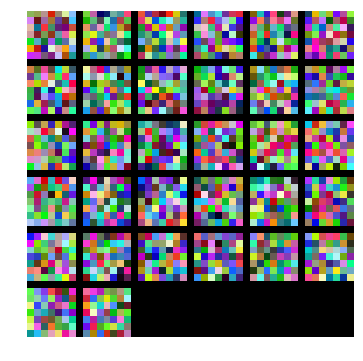

In [34]:
from dl4cv.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [46]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
for inputs, target in test_loader:
    targets = (targets.type(torch.LongTensor))
    inputs, targets = Variable(inputs), Variable(target)
    if final_model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = final_model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.int()
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.621000


## Save the Model

When you are satisfied with your training, you can save the model.

In [47]:
final_model.save("models/classification_cnn.model")

Saving model... models/classification_cnn.model


## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.58 \\
        \left(\frac{58}{\exp(0.58 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.58 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

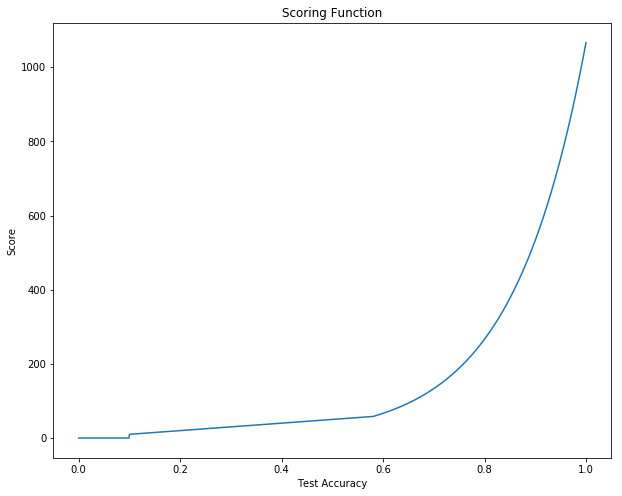

In [48]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.58, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()

## Possible Next Steps

1. Hyperparameter optimization
2. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))
3. Improve your network architecture
    1. Increase network depth
    2. Make network convolutional
    2. Add additional layers such as [Batch normalization](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b#).
